In [1]:
# Student name: Braydon Janecek
# Student pace: full-time
# Scheduled project review date/time: 3/25/2020 - 12:45 PST
# Instructor name: Abhineet 
# Blog post URL: https://bcjanecek.github.io/data_engineering_on_aws_for_data_scientists

# King County Housing Bargain Hunting Overview

## Problem Statement and Approach

Housing prices in King County, WA have been exploding over the past decade due to many factors including the availability of great jobs, a rich culture, and a plethora of outdoor recreation opportunities in the surrounding areas. It is now harder than ever for house hunters to find a bargain in what seems like is a perpetual seller's market. 

My goal in this project to determine where and what types of house are still available at decent prices and develop a multiple linear regression model capable of giving the patient investor an indication whether or not he may be looking at a bargain. Meeting this goal will require careful data cleaning, exploratory data analysis capable of answering questions relating to our goal, thoughtful feature engineering, and finally an iterative approach to mutliple regression modelling. 

## Questions of Interest

1. What is the best time of year (Spring, Summer, Fall, Winter) for an investor to buy a home? 
2. What size houses yield the best deals based on USD/sqft? 
3. Which zip codes are currently yielding the best deals on a USD/sqft basis?

# Initial EDA and Data Cleaning

Here is where we will import any libraries which we may need to complete this project. These will be added on the fly as we progress. 

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

## Initial Data Exploration

Here we will load the dataset and take a look at some of it's properties. 

In [3]:
kc_df = pd.read_csv('kc_house_data.csv')

First we will take a look at the header.

In [4]:
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
kc_df['sqft_basement'].value_counts(normalize=True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
800.0     0.009307
400.0     0.008520
1000.0    0.006853
300.0     0.006575
900.0     0.006575
200.0     0.004862
750.0     0.004815
530.0     0.004769
450.0     0.004769
480.0     0.004769
720.0     0.004538
620.0     0.004167
580.0     0.003889
840.0     0.003843
420.0     0.003751
860.0     0.003658
1100.0    0.003612
670.0     0.003612
780.0     0.003519
550.0     0.003519
650.0     0.003473
240.0     0.003426
380.0     0.003380
680.0     0.003380
360.0     0.003334
            ...   
2580.0    0.000046
588.0     0.000046
2390.0    0.000046
1960.0    0.000046
2120.0    0.000046
225.0     0.000046
172.0     0.000046
248.0     0.000046
3260.0    0.000046
417.0     0.000046
65.0      0.000046
516.0     0.000046
704.0     0.000046
1913.0    0.000046
374.0     0.000046
2350.0    0.000046
875.0     0.000046
2360.0    0.000046
1770.0    0.000046
2250.0    0.000046
2310.0    0.000046
3500.0    0.

A few immediate observations:
1. the zero heavy column that is 'sqft_basement' is going to prove to be an issue for our linear regression model
2. the total sqft of the basement is not an important factor for many people buying a home. Because of this we will likely convert this column into a binary one (i.e. 1 for basement, 0 for no basement). 
3. Because 'sqft_living' is simply the sum of 'sqft_above' and 'sqft_basement' there may be a high level collinearity between these features. Another reason to conver the 'sqft_basement' column to categorical. 

Now let's take a look at the column descriptions which are summarized below.

* **id** - unique identifier for a house
* **dateDate** - data house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/House
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed 
* **condition** - How good the condition is on scale of 1-5 ( Overall )
* **grade** - overall grade given to the housing unit on scale of 0-10
* **sqft_above** - living square footage of house apart from basement
* **sqft_basement** - living square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [6]:
# now let's find out a little more about the dataframe
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


It look's as if the 'waterfront' and 'view' are missing some values - we will make a note to deal with this later during our data cleaning phase. We will likely assume that no value means no waterfront view and no views yet. 

Also, 'date' should be converted to a datetime datatype (I'd also like to extract year for it's own column). 

I'd like to quantify the ranges of the 'grade' and 'condition' columns. Let's do that now - while also taking a look at most common values for all columns.

In [7]:
# print top 5 most frequent values in each column
for col in kc_df.columns:
    print(col, '\n', kc_df[col].value_counts(normalize=True).head(), '\n\n')

id 
 795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64 


date 
 6/23/2014    0.006575
6/26/2014    0.006066
6/25/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64 


price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.381303
1.5    

Immediate observations:
1. Duplicates in the 'id' column - let's take a more in depth look into this in the next step. We want to make sure there are no duplicate value there where there shouldn't be.
2. 'waterfront' is zero for 99.24% of the values. Consider dropping this. 
3. 'grade' appears to be on a scale of 1-10 - we'll confirm this below.
4. 'condition' appears to be on scale of 1-5 - we'll confirm this below. 
5. 'sqft_basement' again has a lot of zero values and a few '?' values. 
6. 'yr_renovated' has a lot of zero values - perhaps turn this to categorical column "renovated in last 15 years, or not"

Everything else is looking good so far!

In [8]:
# check all unique values for 'grade'
grade_values = list(kc_df['grade'].unique())
grade_values.sort()
grade_values

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [9]:
# check all unique values for ''
condition_values = list(kc_df['condition'].unique())
condition_values.sort()
condition_values

[1, 2, 3, 4, 5]

As it turns out our assumption the 'grade' was on a scale from one to ten is wrong! Also, another note these will likely need to be converted to categorical features for modeling purposes. But first it may make sense to put these on a scale of 0-10.

## Data Cleaning and Initial Feature Engineering

Though this is certainly not a particularly "dirty" dataset there are a few steps we could take which will make our data analysis and modeling easier later in this notebook. 

The first thing I wanted to do was to make sure there are no occurences where we have the same house sold on the same day.

In [10]:
# check for identical home / sale date rows
sum(kc_df.duplicated(subset=['id','date']))

0

Good, now we've confirmed we have no duplicate rows. Before I forget I'd like to quickly re-scale the 'grade' column to a scale of 0-10 which is simply more intuitive than a scale of 3-13. 

In [11]:
kc_df['grade'] = kc_df['grade'].map(lambda x: x-3) # map a function to subtract 3 from each value 
grade_values = list(kc_df['grade'].unique()) # confirm that change has taken place
grade_values.sort()
grade_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Next, I'd like to extract the year from date sold. This will be used later in the notebook to adjust home sale prices for inflation. 

In [12]:
# use lambda function to extract last 4 digits (year)
kc_df['year_sold'] = kc_df['date'].apply(lambda x: int(x[-4:])) 

Now we will extract the month sold from this dataframe. This will be easier if we convert 'date' to datetime object first. 

In [13]:
# this will be easier if we convert this to datetime first
kc_df['date'] = pd.to_datetime(kc_df['date'])
# now we can extract the date
kc_df['month_sold'] = kc_df['date'].dt.month

Next we will create a new column which indicates the season of sale. It will be helpful to first create a mapable function as we will below. 

In [14]:
def season(month):
    if month == 12 or 1 <= month <= 2:
        season = 'Winter'
    elif 3 <= month <= 5:
        season = 'Spring'
    elif 6 <= month <= 8:
        season = 'Summer'
    else:
        season = 'Fall'
    return season

In [15]:
# now we will apply our new function to our newly created month column
kc_df['season_sold'] = kc_df['month_sold'].apply(season)

In [16]:
# let's take a quick peak at that distribution
kc_df['season_sold'].value_counts(normalize=True)

Spring    0.301801
Summer    0.293004
Fall      0.234107
Winter    0.171089
Name: season_sold, dtype: float64

Next we will want to do some initial feature engineering work by binning discrete data which is disguised as continous data. These columns include bedrooms, bathrooms, year built, and year renovated. We also want to work on the 'sqft_basement' and 'view' columns to make them easier to work with. 

Let's start with 'sqft_basement'. To recap what we realized earlier. 

1. The zero heavy column that is 'sqft_basement' is going to prove to be an issue for our linear regression model
2. The total sqft of the basement is not an important factor for many people buying a home. Therefore this column makes the most sense as a binary one (i.e. 1 for basement, 0 for no basement).
3. Because 'sqft_living' is simply the sum of 'sqft_above' and 'sqft_basement' there may be a high level collinearity between these features. Another reason to conver the 'sqft_basement' column to categorical.

With all that said, let's convert this column to a binary variable.

In [17]:
# first we need to deal with the '?' and '0.0' values in the column, we will assume this means no basement
kc_df['sqft_basement'] = kc_df['sqft_basement'].map(lambda x: 0 if x == '?' else x)

In [18]:
# we also need to convert this column to 'float' data format
kc_df['sqft_basement'] = kc_df['sqft_basement'].astype('float')

In [19]:
# create new binary column called basement
kc_df['basement'] = kc_df['sqft_basement'].map(lambda x: 1 if x > 0 else 0)

In [20]:
# drop the 'sqft_basement' column
kc_df = kc_df.drop(['sqft_basement'], axis=1)

No that we've taken care of that, I'd like to deal with the outliers we have in our no categorical data. We will eliminate rows which contain variables whose values are more than 3 standard deviations above or below the mean. These variables include the following.

In [21]:
non_cat_variables = ['price', 'bedrooms', 'bathrooms', 'yr_built', 'sqft_living', 'sqft_lot', 'sqft_above', 'lat', 'long', 
                     'sqft_living15', 'sqft_lot15']

for var in non_cat_variables:
    # remove all rows which contain value more than three standard deviations away from mean
    kc_df = kc_df[np.abs(kc_df[var]-kc_df[var].mean()) <= (3*kc_df[var].std())]


Note that above I made the decision to include price in the outlier detection for loop. I did this because our current investment model is not interested in those higher end homes. We will leave the analysis of those homes for another project. Furthermore, dropping these values resulted in less than 1% information loss. 

Now that we've removed serious outliers I'd like to create bins for the 'bedrooms', 'bathrooms', 'yr_built' columns. The scatterplots below show that these predictors behave more like categorical values so we will treat them as such. We do not want our model later mistaking these discrete values as continous variables.

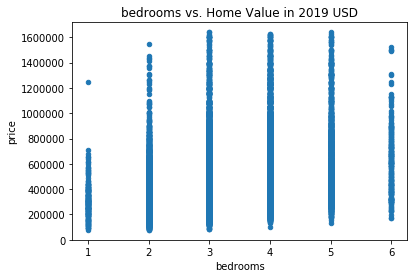

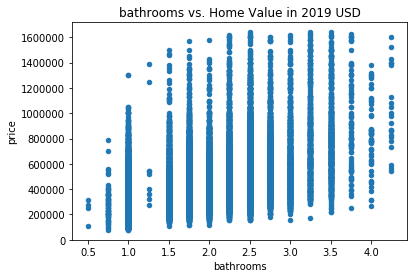

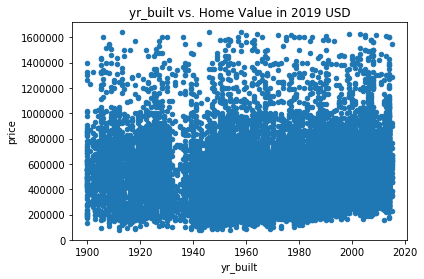

In [22]:
# let's take a look at the scatter plots to show how these behave more like discrete variables
to_categorical = ['bedrooms', 'bathrooms', 'yr_built']

for column in to_categorical:
    kc_df.plot.scatter(x=column, y='price')
    plt.title("{} vs. Home Value in 2019 USD".format(column))
    plt.show()

Now let's take a look at their histograms to get a better idea of how to bin them.

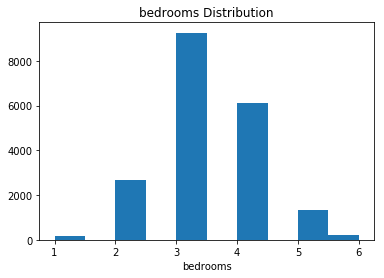

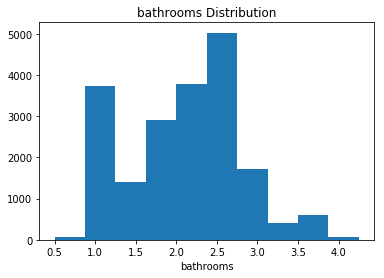

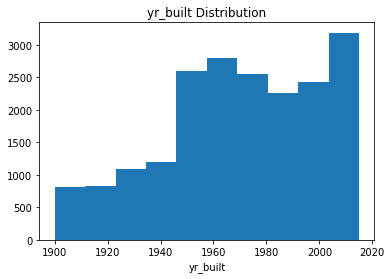

In [23]:
for column in to_categorical:
    plt.hist(kc_df[column])
    plt.xlabel(column)
    plt.title("{} Distribution".format(column))
    plt.show()

In [24]:
# and we will also take a look at their summary statistics
for column in to_categorical:
    print(kc_df[column].describe())

count    19764.000000
mean         3.321443
std          0.859298
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: bedrooms, dtype: float64
count    19764.000000
mean         2.039820
std          0.689073
min          0.500000
25%          1.500000
50%          2.000000
75%          2.500000
max          4.250000
Name: bathrooms, dtype: float64
count    19764.000000
mean      1969.928861
std         29.437354
min       1900.000000
25%       1950.000000
50%       1972.000000
75%       1995.000000
max       2015.000000
Name: yr_built, dtype: float64


In [25]:
# based on some intuition and the quantile distributions described above, we will define our bin ranges
# as follows
yr_built_bins = [1900, 1950, 1975, 2000, 2015] # mostly used quantiles to determine these
bathrooms_bins = [0, 1, 2, 3, 4, 5] # include all to reduce information loss
bedrooms_bins = [0, 1, 2, 3, 4, 6] # include all to reduce information loss

In [26]:
# now lets convert these columns to binned categories
# note that when binning these, the default setting is that the values on the right are included in the bin
kc_df['yr_built'] = pd.cut(kc_df['yr_built'], yr_built_bins)
kc_df['bathrooms'] = pd.cut(kc_df['bathrooms'], bathrooms_bins)
kc_df['bedrooms'] = pd.cut(kc_df['bedrooms'], bedrooms_bins)

In [27]:
kc_df['yr_built'].value_counts(normalize=True)

(1950, 1975]    0.277817
(1975, 2000]    0.271568
(1900, 1950]    0.247028
(2000, 2015]    0.203587
Name: yr_built, dtype: float64

In [28]:
kc_df['bathrooms'].value_counts(normalize=True)

(2, 3]    0.440346
(1, 2]    0.311627
(0, 1]    0.192977
(3, 4]    0.053936
(4, 5]    0.001113
Name: bathrooms, dtype: float64

In [29]:
kc_df['bedrooms'].value_counts(normalize=True)

(2, 3]    0.468579
(3, 4]    0.310666
(1, 2]    0.134538
(4, 6]    0.076857
(0, 1]    0.009360
Name: bedrooms, dtype: float64

Now that we have bedrooms, bathrooms, and yr_built binned neatly I'd like to turn our attention to the 'yr_renovated' column. From my point of view, the only way a renovation matters is if an older home (pre-1980's) was improved upon structurally and / or mechanically. If the renovation was done before then, the building technologies are now obsolete and it doesn't matter anymore. Furthermore, any renovation done since then will be reflected in the overall 'grade' and 'condtion' columns and is therefore redundant data. Therefore, I'd like to turn this bin into "Renovated Since 1980". 

In [30]:
# let's first define a function which we may map 
def renovation(year):
    if year >= 1980:
        return 1
    else:
        return 0

In [31]:
# now let's apply our new function to the 'yr_renovated' column
kc_df['yr_renovated']  = kc_df['yr_renovated'].apply(renovation)

# and let's rename the column
kc_df.rename({'yr_renovated': 'Renovated_since_1980'}, axis=1, inplace=True)

In [32]:
# let's take a quick peak at our data
kc_df['Renovated_since_1980'].value_counts()

0    19217
1      547
Name: Renovated_since_1980, dtype: int64

Finally, for our initial data scrubbing I'd like to take care of the 'view' column. Let's simplify this to whether or not the house has been viewed. 

In [33]:
# first we'll write our function for binary classification
def views(count):
    if count > 0:
        return 1
    else:
        return 0

In [34]:
# and now we can apply this to our column
kc_df['view'] = kc_df['view'].apply(views)
# and rename the column
kc_df.rename({'view': 'viewed'}, axis=1, inplace=True)

In [35]:
kc_df['viewed'].value_counts(normalize=True)

0    0.918488
1    0.081512
Name: viewed, dtype: float64

Finally, we'll remove thouse pesky NaN values from the 'waterfront' column.

In [36]:
# almost forgot this; let's fill the NaN values in waterfront with zero
kc_df['waterfront'] = kc_df['waterfront'].fillna(0)

Great, our data is now clean enough to really start to analyze it. Note that the following columns will be one-hot encoded (bedrooms, bathrooms, season sold, yr_built, grade, condition) during main feature engineering portion of notebook.

## Target Variable Analysis

During this portion of the project we'd like to analyze our target variable (home value) in more depth. This analysis will include plotting scatter plots (continuous data) and violin and/or box plots (categorical data) against our target variable and see what type of patterns we can find. This will also give us an opportunity to identify any glaringly obvious outliers and remove them in preparation for modeling. 

The first task I would like to do here is create a column which includes inflation adjusted pricing data which will be our target variable in our modeling phase. This pricing data will be based on OECD data which I've imported into a csv which may now be loaded. It includes a column I've engineered which contains multipliers for various years to reference 2019 dollars. 

NOTE: After beginning this I realized that our data only shows houses sold in 2014 and 2015 (i.e. inflation is not really a factor). However, since I've already done most of the work I'm going to proceed to create a column for home sale price in 2019 dollars. Also, this will still prove to be a useful part of the data pipeline if we ever receive data for a larger range. 

In [37]:
# load the CSV I created earlier
df = pd.read_csv('CPI_multiplier.csv')

In [38]:
# now we will extract only the columns we are interested in 
CPI_multiplier = df[['Year','Price Multiplier (2019 Reference Year)']]

In [39]:
# let's rename the columns for simplicity
CPI_multiplier.columns = ['Year', 'Multiplier']

In [40]:
# make sure that Multiplier is a float value
CPI_multiplier['Multiplier'] = CPI_multiplier['Multiplier'].astype('float')

# make sure this warning gets ignored

Now let's merge our new CPI_multiplier dataframe with our kc_df dataframe. 

In [41]:
# merge this with our kc_df on 'year_sold' and 'Year' columns
kc_df = kc_df.merge(CPI_multiplier, left_on='year_sold', right_on='Year')
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,viewed,...,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,season_sold,basement,Year,Multiplier
0,7129300520,2014-10-13,221900.0,"(2, 3]","(0, 1]",1180,5650,1.0,0.0,0,...,47.5112,-122.257,1340,5650,2014,10,Fall,0,2014,1.079237
1,6414100192,2014-12-09,538000.0,"(2, 3]","(2, 3]",2570,7242,2.0,0.0,0,...,47.7210,-122.319,1690,7639,2014,12,Winter,1,2014,1.079237
2,2487200875,2014-12-09,604000.0,"(3, 4]","(2, 3]",1960,5000,1.0,0.0,0,...,47.5208,-122.393,1360,5000,2014,12,Winter,1,2014,1.079237
3,1321400060,2014-06-27,257500.0,"(2, 3]","(2, 3]",1715,6819,2.0,0.0,0,...,47.3097,-122.327,2238,6819,2014,6,Summer,0,2014,1.079237
4,9212900260,2014-05-27,468000.0,"(1, 2]","(0, 1]",1160,6000,1.0,0.0,0,...,47.6900,-122.292,1330,6000,2014,5,Spring,1,2014,1.079237


Finally we can create a new column, 'price_2019', which will show the price our the house sold in 2019 dollars. 

In [42]:
kc_df['price_2019'] = kc_df.apply(lambda row: row['price']*row['Multiplier'], axis=1)

In [43]:
# lets get these out of scientific notation to make it easier to work with
kc_df['price_2019'] = kc_df['price_2019'].map(lambda x: round(x,0))
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,viewed,...,long,sqft_living15,sqft_lot15,year_sold,month_sold,season_sold,basement,Year,Multiplier,price_2019
0,7129300520,2014-10-13,221900.0,"(2, 3]","(0, 1]",1180,5650,1.0,0.0,0,...,-122.257,1340,5650,2014,10,Fall,0,2014,1.079237,239483.0
1,6414100192,2014-12-09,538000.0,"(2, 3]","(2, 3]",2570,7242,2.0,0.0,0,...,-122.319,1690,7639,2014,12,Winter,1,2014,1.079237,580630.0
2,2487200875,2014-12-09,604000.0,"(3, 4]","(2, 3]",1960,5000,1.0,0.0,0,...,-122.393,1360,5000,2014,12,Winter,1,2014,1.079237,651859.0
3,1321400060,2014-06-27,257500.0,"(2, 3]","(2, 3]",1715,6819,2.0,0.0,0,...,-122.327,2238,6819,2014,6,Summer,0,2014,1.079237,277904.0
4,9212900260,2014-05-27,468000.0,"(1, 2]","(0, 1]",1160,6000,1.0,0.0,0,...,-122.292,1330,6000,2014,5,Spring,1,2014,1.079237,505083.0


Now that we have our prices normalized to 2019 USD I'd like to quickly check out the distribution of our target variable. Before proceeding though I'd like to quickly remove any columns from our dataframe we no longer need. 

In [44]:
kc_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'viewed', 'condition', 'grade',
       'sqft_above', 'yr_built', 'Renovated_since_1980', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold',
       'season_sold', 'basement', 'Year', 'Multiplier', 'price_2019'],
      dtype='object')

In [45]:
kc_df = kc_df.drop(['date', 'Year', 'Multiplier', 'price'], axis=1)

In [46]:
# first let's identify our quantiles
quantile_25 = np.percentile(kc_df['price_2019'], 25)
quantile_50 = np.percentile(kc_df['price_2019'], 50)
quantile_75 = np.percentile(kc_df['price_2019'], 75)

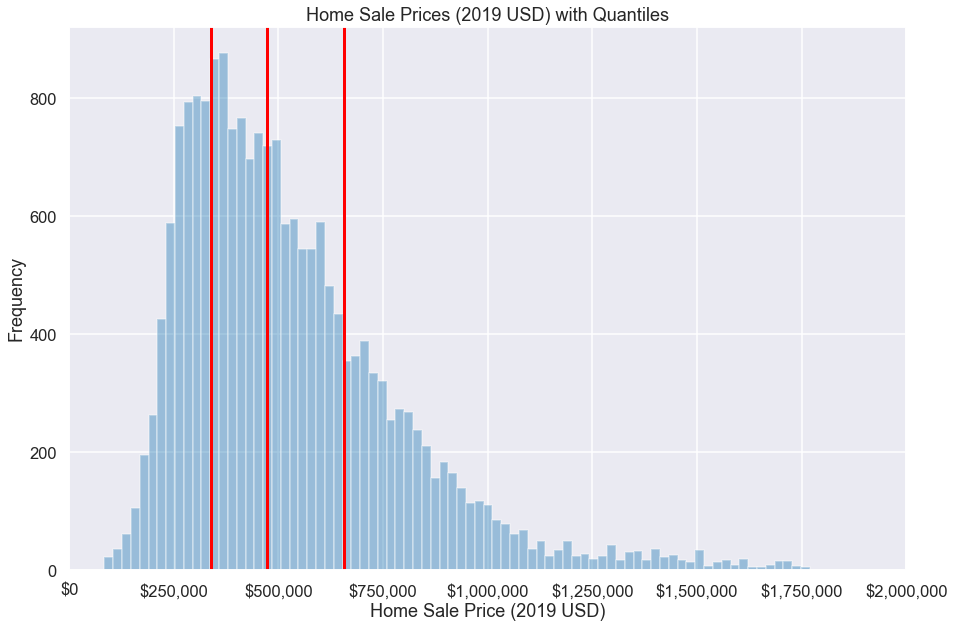

In [47]:
# set style and context
sns.set_style('darkgrid')
sns.set_context('talk')

# initialize fig and ax
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot distplot 
sns.distplot(kc_df['price_2019'], bins=80, kde=False)

# set xlim, title, axes labels, and tickers
plt.xlim(0,2000000) # condense plot for better viewing
plt.title("Home Sale Prices (2019 USD) with Quantiles") # set title
plt.ylabel("Frequency")
plt.xlabel("Home Sale Price (2019 USD)")
fmt = '${x:,.0f}' # format to feed into mtick.StrMethodFormatter, include $ sign
tick = mtick.StrMethodFormatter(fmt) # set tick style
ax.xaxis.set_major_formatter(tick)  # apply tick style to x axis
# now place vertical lines in locations of quantiles
ax.axvline(x=quantile_25, linewidth=3, color='r')
ax.axvline(x=quantile_50, linewidth=3, color='r')
ax.axvline(x=quantile_75, linewidth=3, color='r')

Now we'd like to take a look at the relationship our target variable has with the independent variables. We will do this using scatter plots (specifically Seaborn regplots) for the continuous variables and boxplots for the categorical features. 

Note using regplots will also allow us to get a better idea of there is a linear relationship between a feature and our target variable. 

In [48]:
# let's make a list of our continous variables
continuous_variables = ['sqft_living', 'sqft_lot', 'sqft_above', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

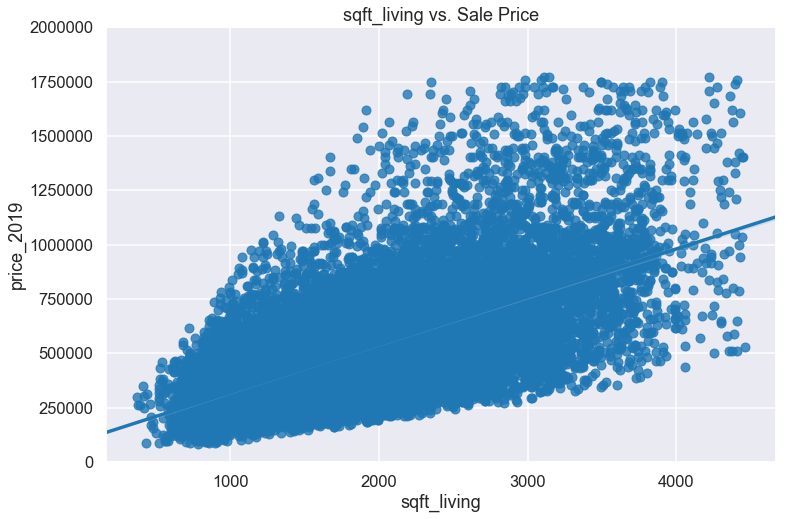

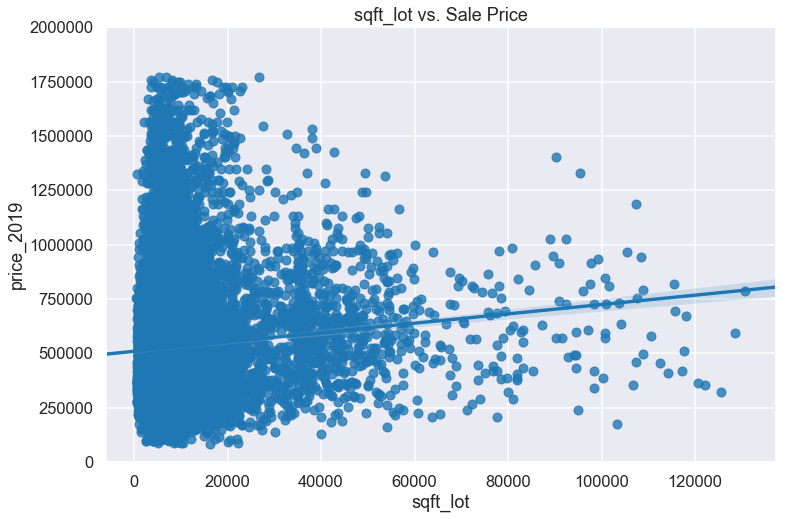

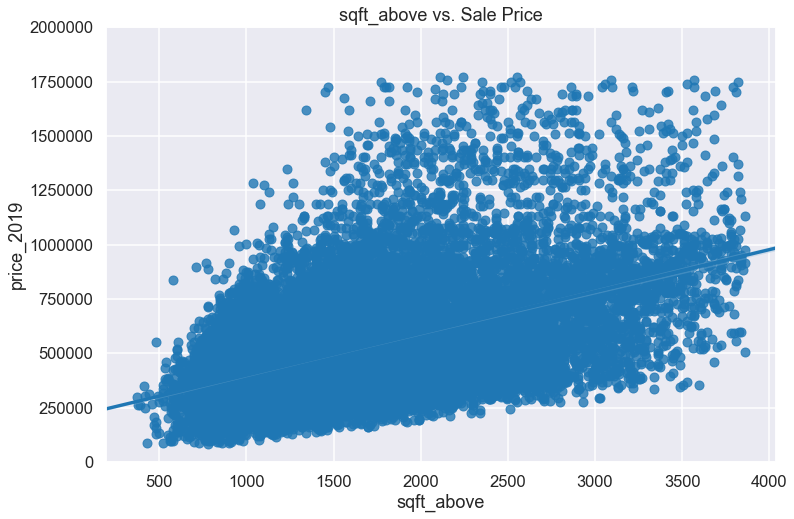

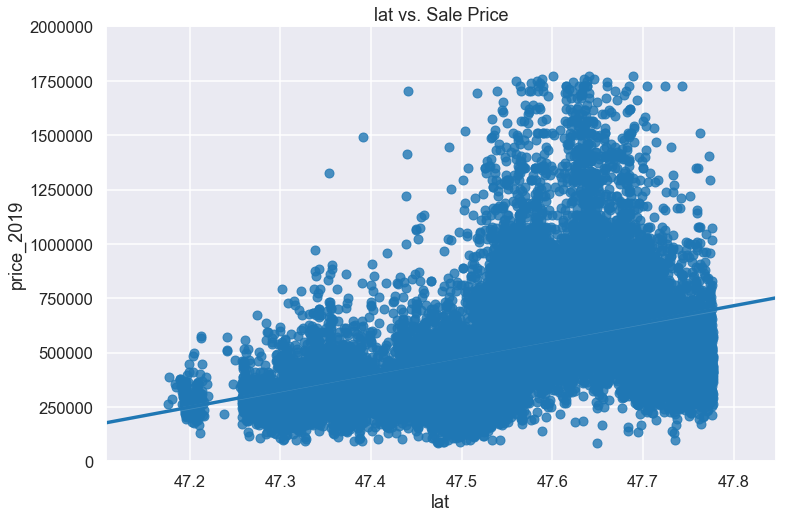

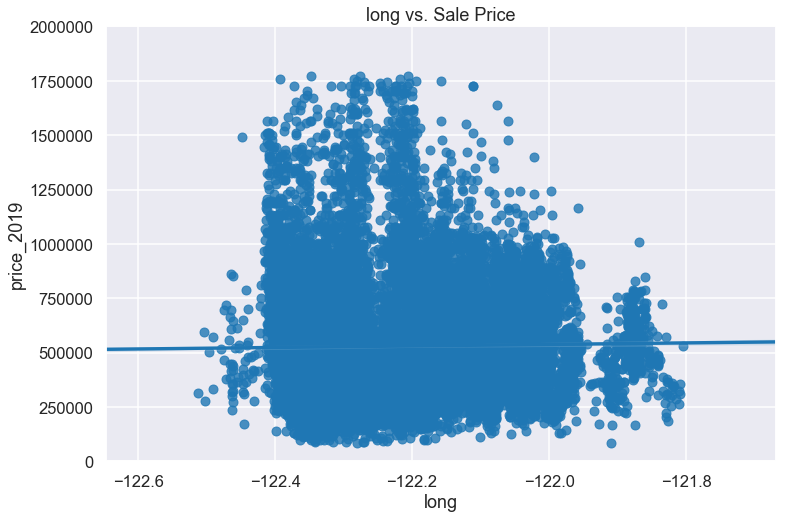

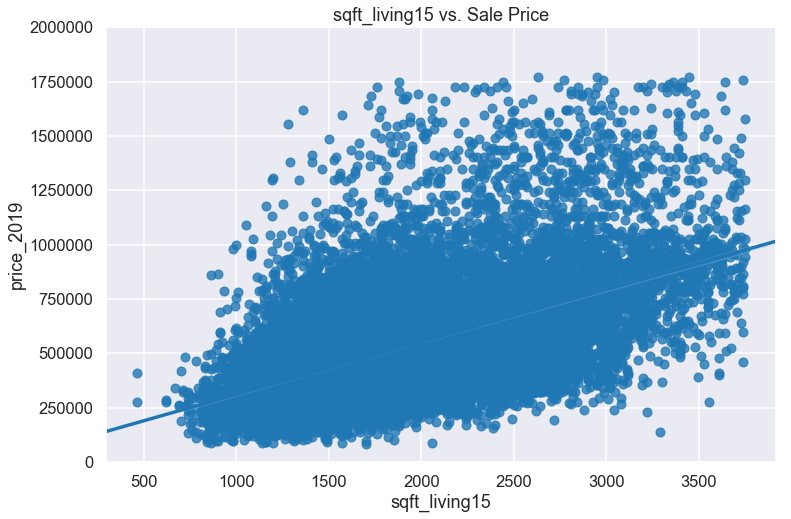

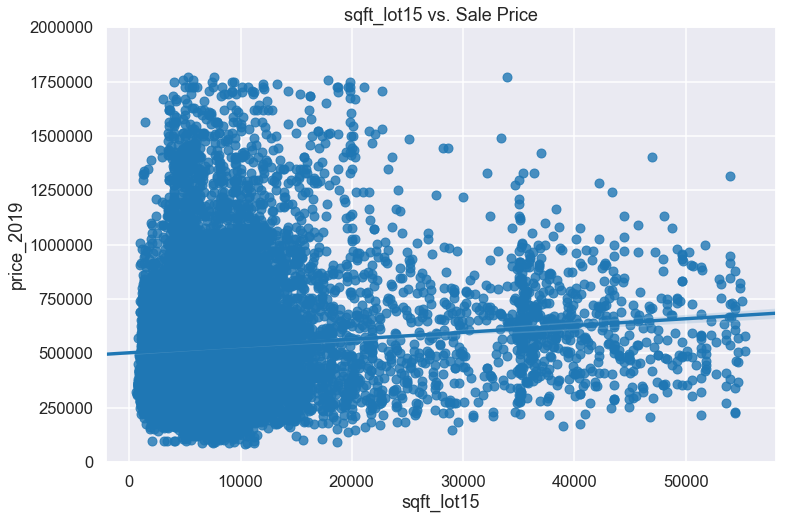

In [49]:
# now let's plot each continuous feature against sale price
for variable in continuous_variables:
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    plt.ylim(0,2000000)
    sns.regplot(x=variable, y='price_2019', data=kc_df)
    plt.title("{} vs. Sale Price".format(variable))

Interestingly, it appears that prices go up the further north you go. It doesn't appear that longitude has any sort of relationship with price so this variable will likely be exclued from our linear regression model. 

In [50]:
# let's make a list of our categorical variables
categorical_variables = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'viewed', 'condition', 'grade', 
                         'yr_built', 'Renovated_since_1980', 'zipcode', 'year_sold', 'month_sold', 'season_sold',
                         'basement']

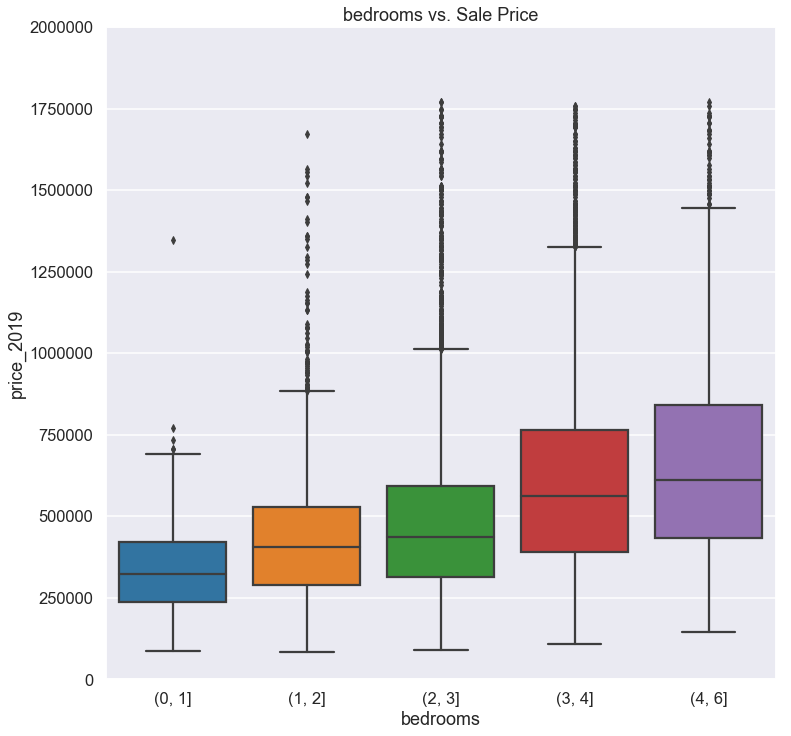

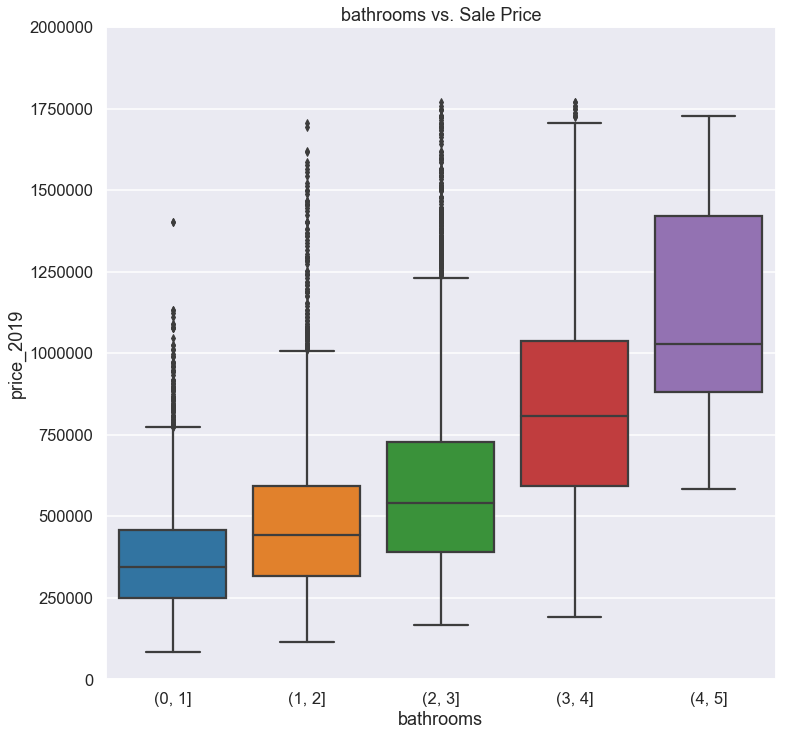

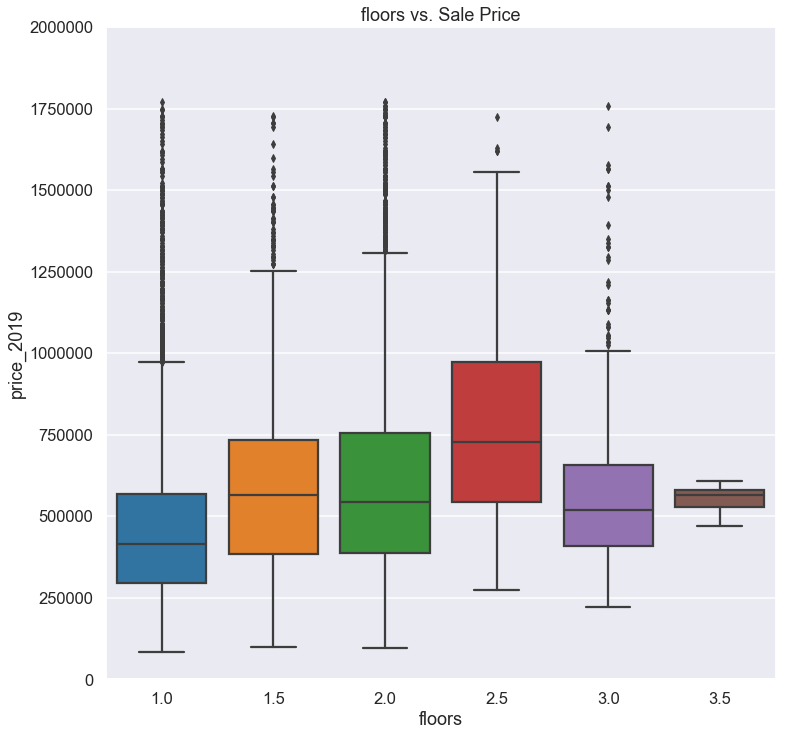

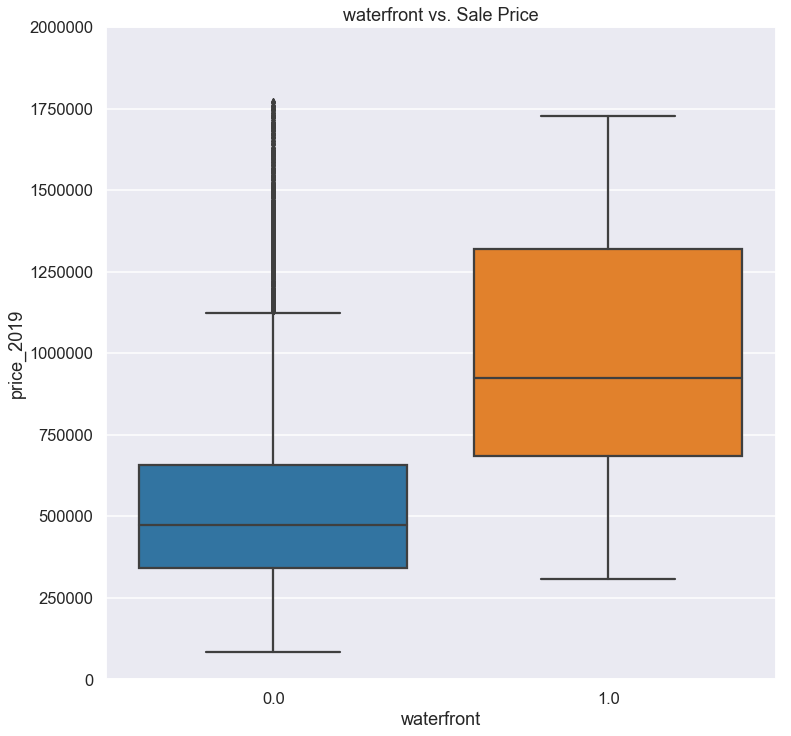

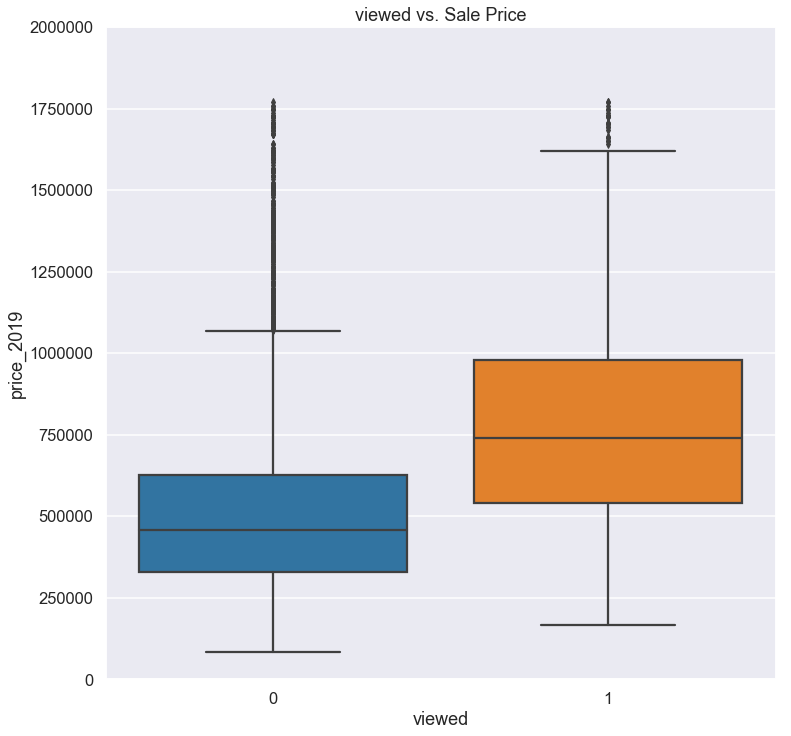

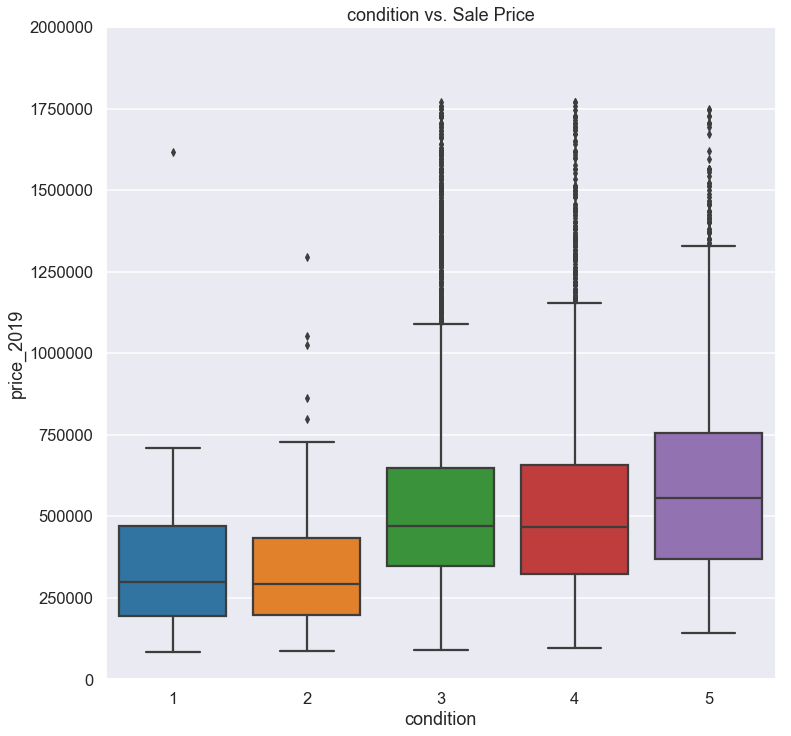

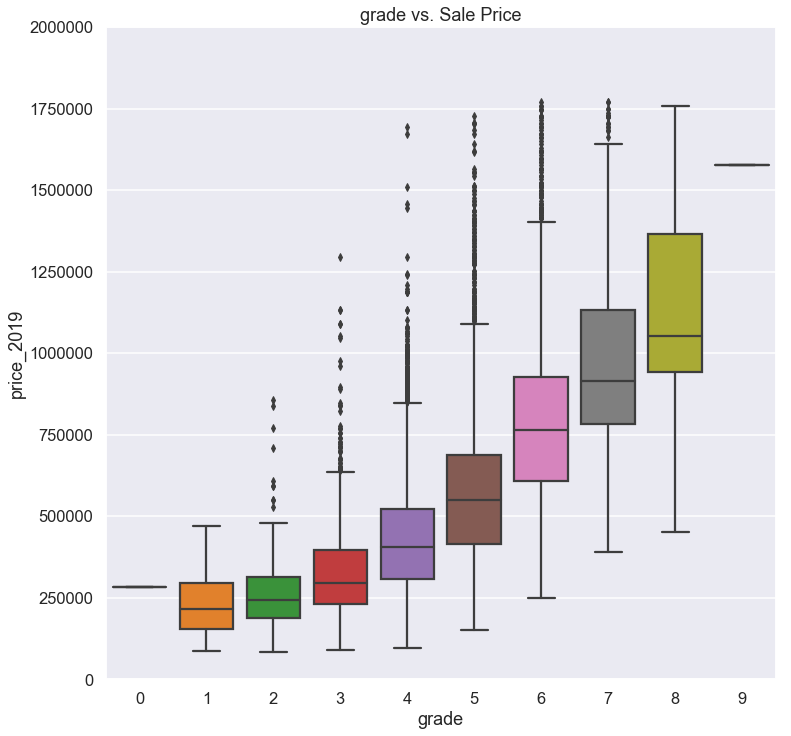

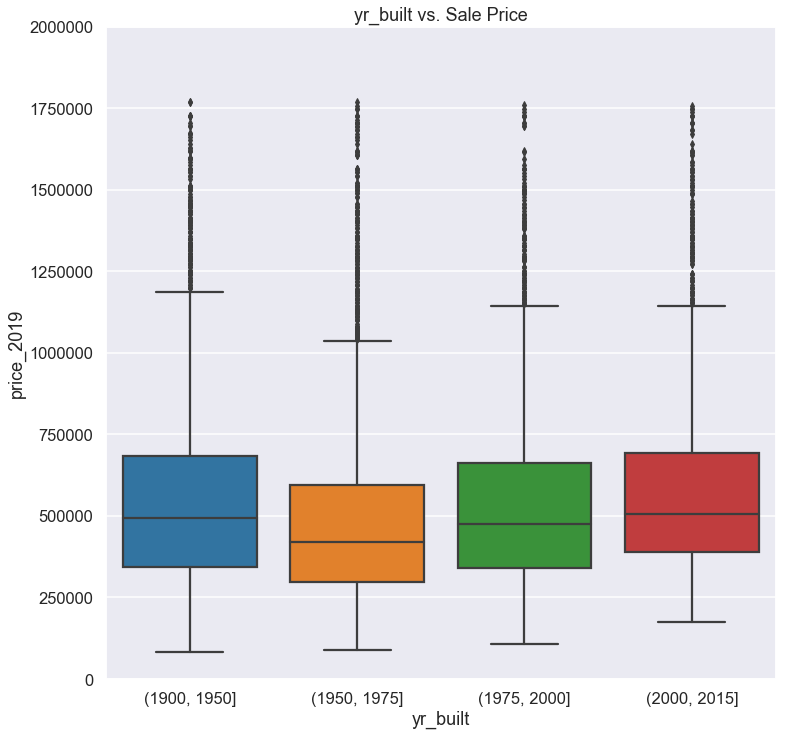

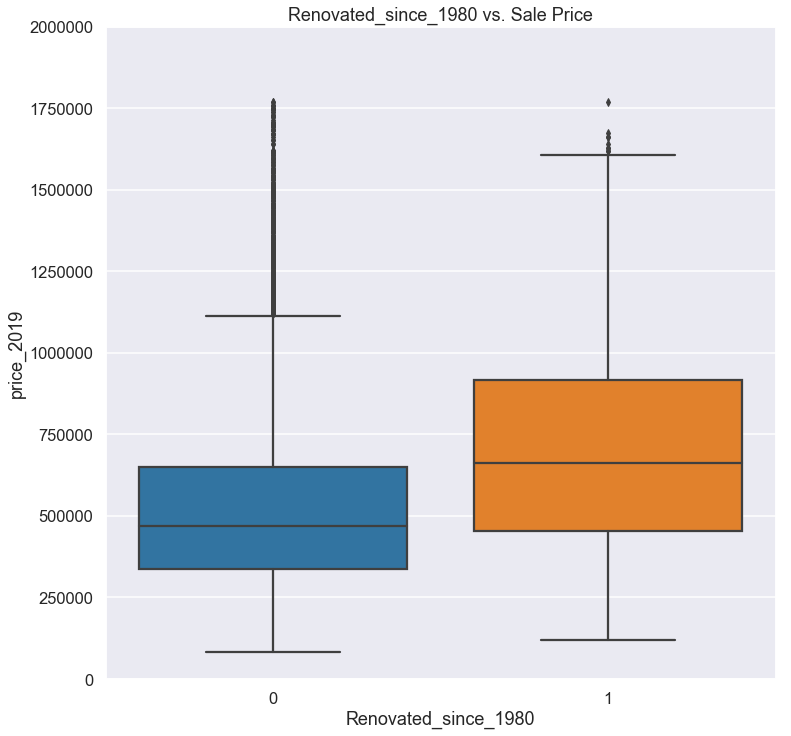

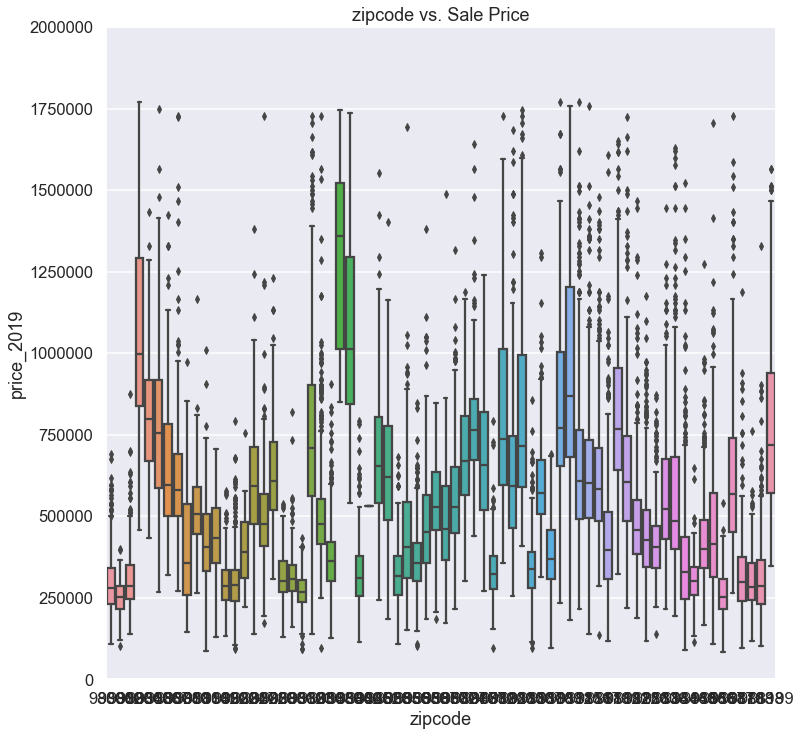

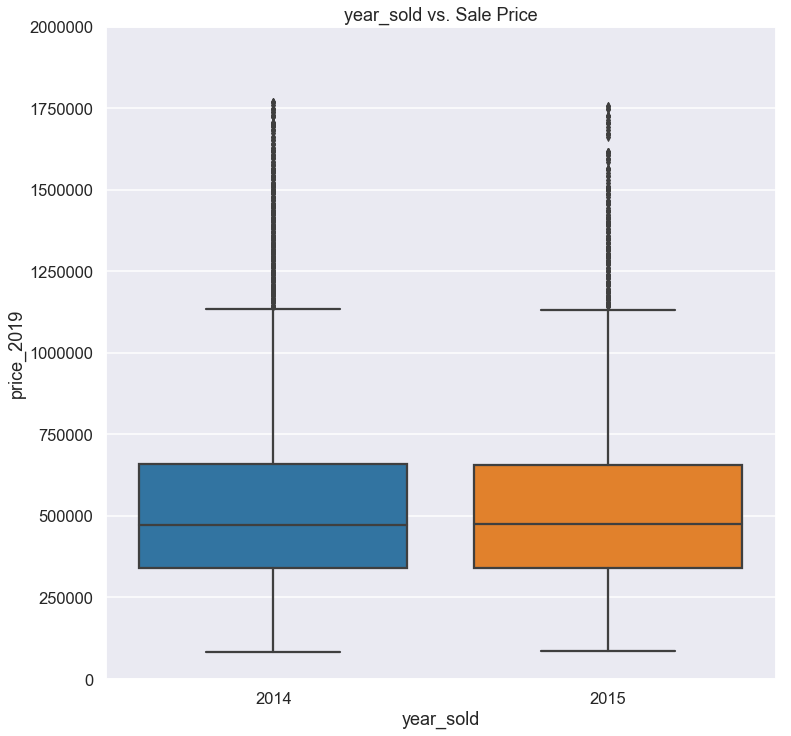

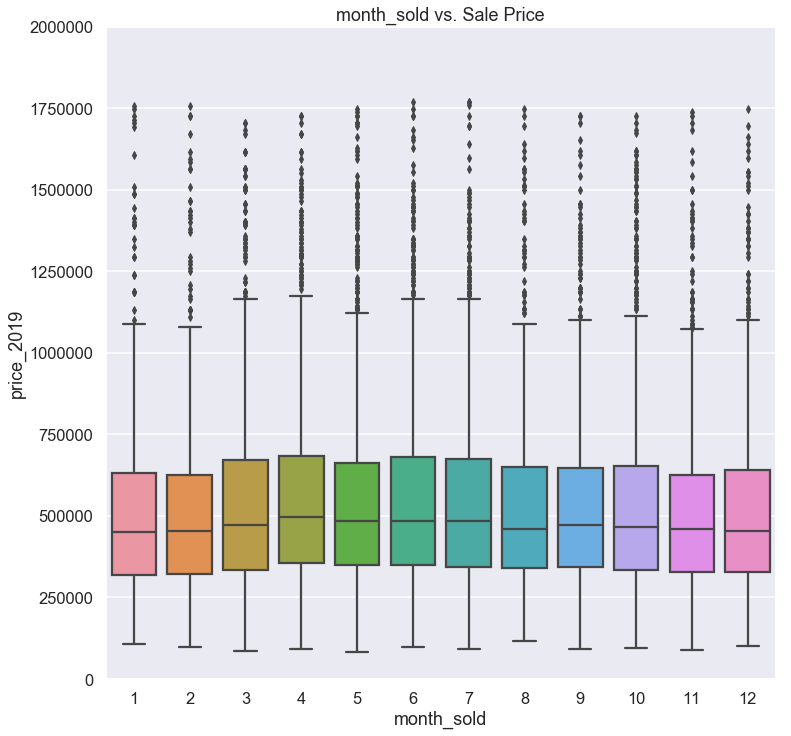

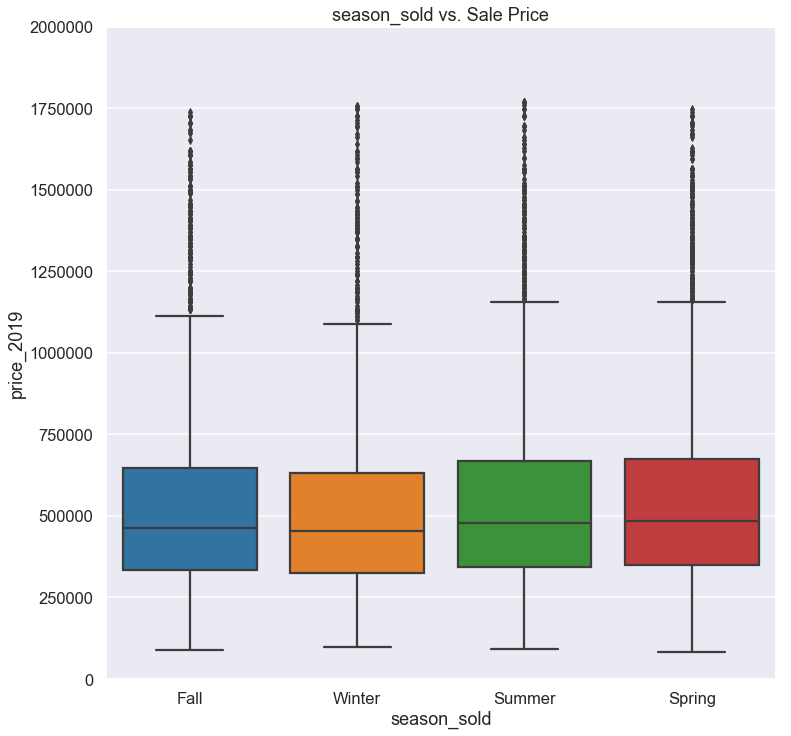

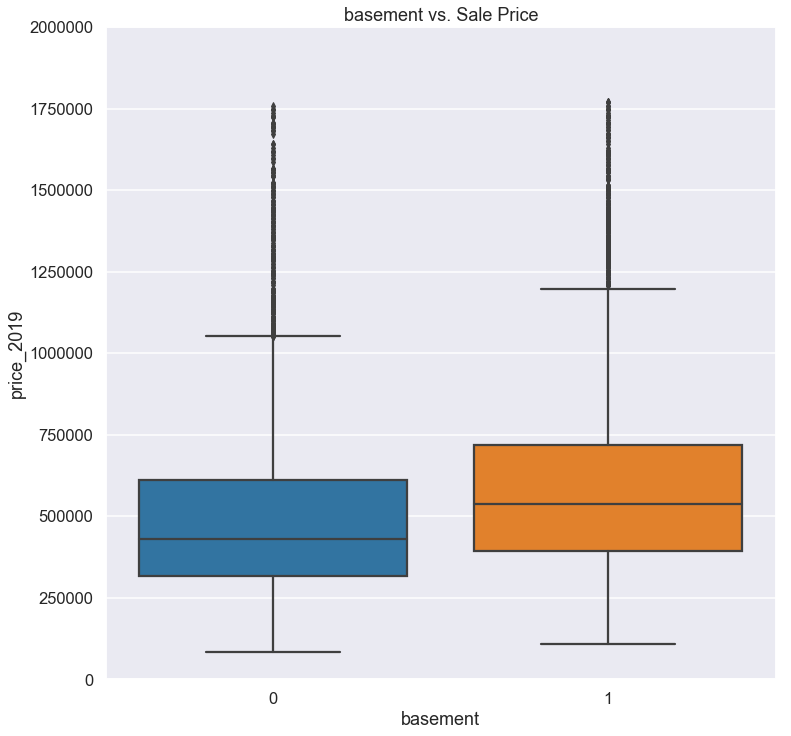

In [51]:
# now let's plot each categorical feature against sale price
for variable in categorical_variables:
    ax, figure = plt.subplots(1,1,figsize=(12,12))
    plt.ylim(0,2000000)
    sns.boxplot(x=variable, y='price_2019', data=kc_df)
    plt.title("{} vs. Sale Price".format(variable))

# Best Time of Year to Buy New Property

In [52]:
# lets look at median home sale prices in different seasons
kc_df_season_median = kc_df.groupby('season_sold')['price_2019'].median()
kc_df_season_median

season_sold
Fall      464072.0
Spring    485172.0
Summer    477563.0
Winter    452827.0
Name: price_2019, dtype: float64

In [53]:
# lets look at median home sale prices in different months
kc_df_month_median = kc_df.groupby('month_sold')['price_2019'].median()
kc_df_month_median

month_sold
1     451749.0
2     452719.0
3     472773.0
4     495953.0
5     485171.5
6     485657.0
7     484550.5
8     458676.0
9     472166.0
10    467310.0
11    458676.0
12    453280.0
Name: price_2019, dtype: float64

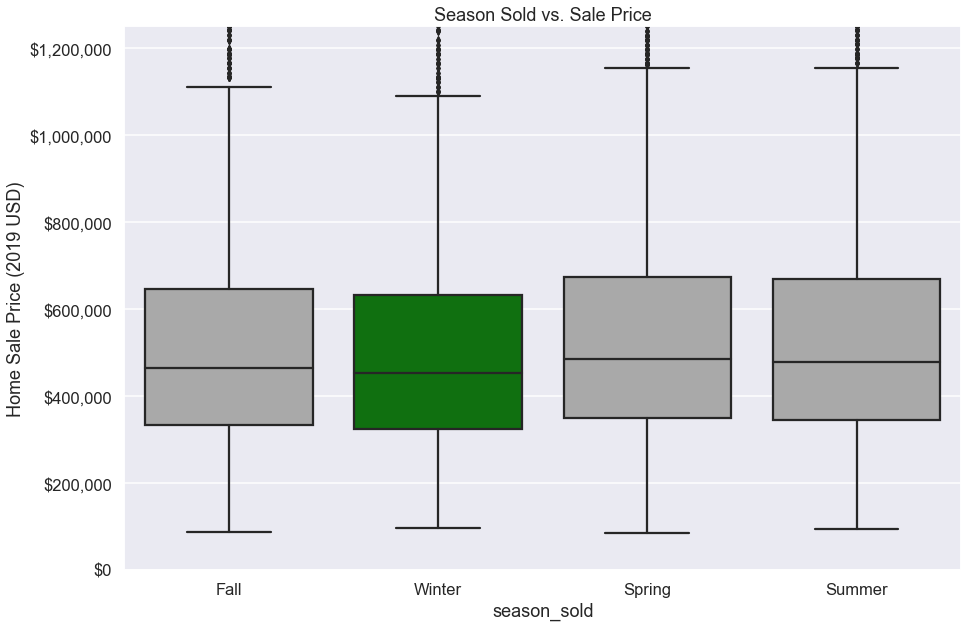

In [54]:
# season sold vs. sale price

# set style and context
sns.set_style('darkgrid')
sns.set_context('talk')

# specify palette to highlight best months to buy house
my_pal = {season_sold: "g" if season_sold == 'Winter' else "darkgrey" for season_sold in kc_df.season_sold.unique()} 

# initialize figure and create boxplot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.boxplot(x=kc_df['season_sold'], y='price_2019', data=kc_df, palette=my_pal, order=['Fall', 'Winter', 'Spring', 'Summer'])

# specify labels and limits
plt.title("Season Sold vs. Sale Price")
plt.ylabel("Home Sale Price (2019 USD)")
plt.ylim(0,1250000)

# format y tickers
fmt = '${x:,.0f}' # format to feed into mtick.StrMethodFormatter, include $ sign
tick = mtick.StrMethodFormatter(fmt) # set tick style
ax.yaxis.set_major_formatter(tick)  # apply tick style to x axis

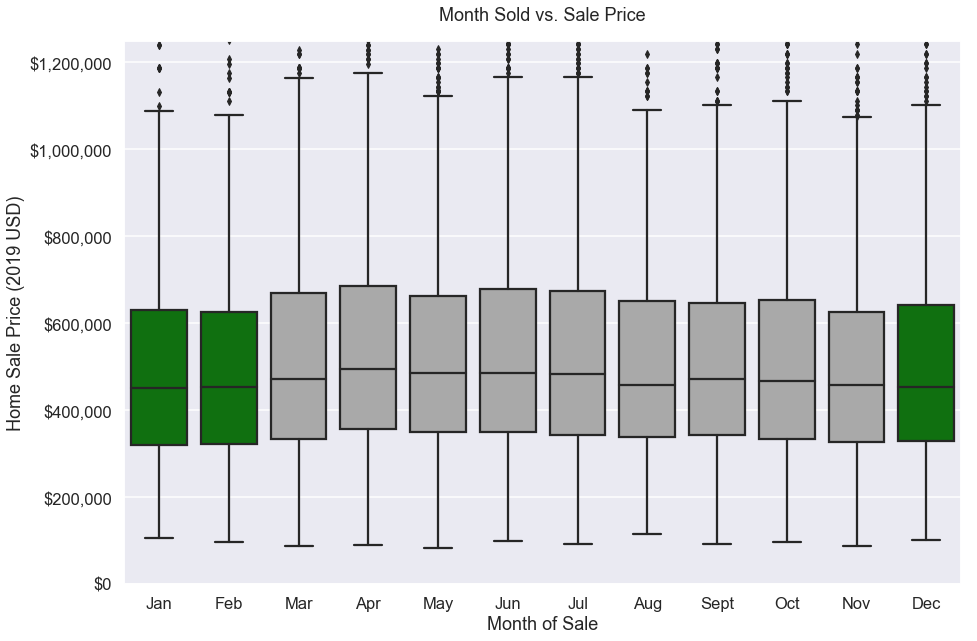

In [55]:
# month sold vs. sale price

# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# specify palette to highlight best months to buy house
my_pal = {month_sold: "g" if month_sold == 12 or month_sold == 1 or month_sold == 2 
                          else "darkgrey" for month_sold in kc_df.month_sold.unique()} 

# initialize figure and create boxplot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.boxplot(x=kc_df['month_sold'], y='price_2019', data=kc_df, palette=my_pal)

# specify labels and limits
plt.title("Month Sold vs. Sale Price", pad=20)
plt.ylabel("Home Sale Price (2019 USD)")
plt.xlabel("Month of Sale")
plt.ylim(0,1250000)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                                                     'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])

# format y tickers
fmt = '${x:,.0f}' # format to feed into mtick.StrMethodFormatter, include $ sign
tick = mtick.StrMethodFormatter(fmt) # set tick style
ax.yaxis.set_major_formatter(tick)  # apply tick style to x axis

In [56]:
# final analysis
best_month = kc_df_month_median.min()
worst_month = kc_df_month_median.max()
overpay_in_april = round(((worst_month - best_month) / best_month*100),2)
print("Based on median home sale prices you pay about {}% more for a house sold in April than a house sold in January".format(overpay_in_april))

Based on median home sale prices you pay about 9.79% more for a house sold in April than a house sold in January


# Home Sizes with Best per Square Foot Pricing

In [57]:
# create new column with price per square foot
kc_df['price_per_sf'] = kc_df.apply(lambda row: row['price_2019'] / row['sqft_living'], axis=1)

In [58]:
# bin house sizes and group by house size - first define function
def house_size(sqft):
    if sqft < 1000:
        home_size = '< 1000 sqft'
    elif 1000 <= sqft < 2000:
        home_size = '1000 to 2000 sqft'
    elif 2000 <= sqft < 3000:
        home_size = '2000 to 3000 sqft'
    elif 3000 <= sqft < 4000:
        home_size = '3000 to 4000 sqft'
    else:
        home_size = '> 4000 sqft'
    return home_size
        
# apply function to house size column in new dataframe
kc_df['house_size'] = kc_df['sqft_living'].apply(house_size)

Text(0.5, 0, 'House Size')

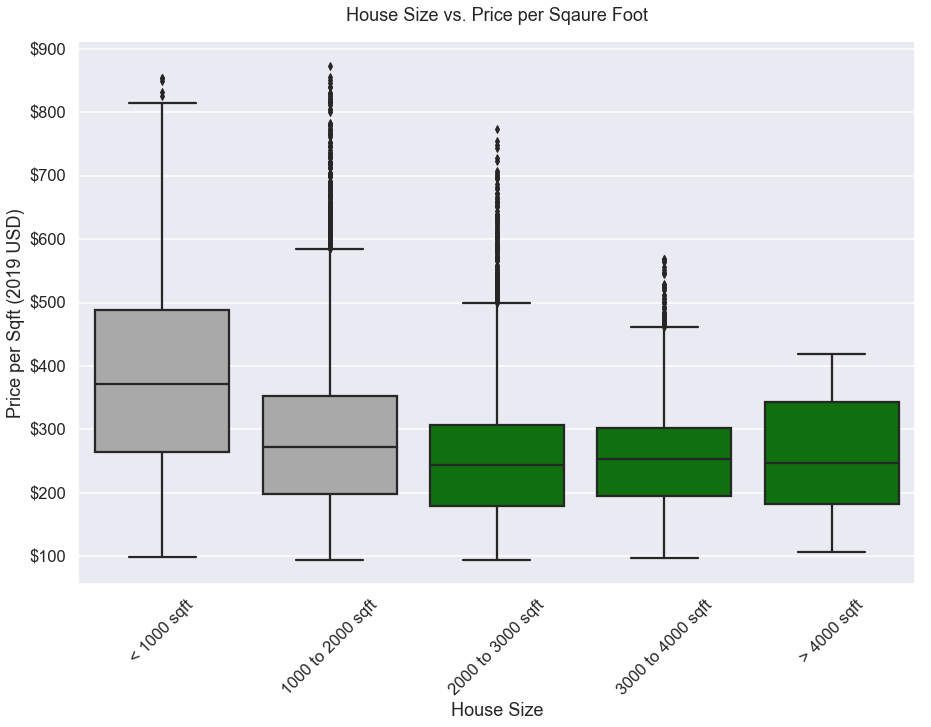

In [59]:
# initialize figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# define color palette
my_pal = {house_size: "g" if house_size == '2000 to 3000 sqft' or house_size == '3000 to 4000 sqft' or house_size == '> 4000 sqft' 
                          else "darkgrey" for house_size in kc_df.house_size.unique()} 

# look at price per sqft vs. house size
sns.boxplot(x='house_size', y='price_per_sf', data=kc_df, 
            order=['< 1000 sqft', '1000 to 2000 sqft', '2000 to 3000 sqft', '3000 to 4000 sqft', '> 4000 sqft'],
            palette=my_pal)

# format x ticks                                                 
plt.xticks(rotation='45')

# format y tickers
fmt = '${x:,.0f}' # format to feed into mtick.StrMethodFormatter, include $ sign
tick = mtick.StrMethodFormatter(fmt) # set tick style
ax.yaxis.set_major_formatter(tick)  # apply tick style to x axis

# set labels and title
plt.title("House Size vs. Price per Sqaure Foot", pad=20)
plt.ylabel("Price per Sqft (2019 USD)")
plt.xlabel("House Size")

In [60]:
# finally drop 'house_size' column 
kc_df = kc_df.drop(['house_size'], axis=1)

# Neighborhoods with Best Deals

Before we forget, let's redefine our 'kc_df' and call it our 'kc_df_cleaned' since we have done most of the cleaning for this data. 

In [61]:
kc_df_cleaned = kc_df

In [62]:
# export latest cleaned dataframe to csv for use in Tableau
kc_df_cleaned.to_csv(r'C:\Users\bjane\flatiron-ds-course\module02\final_project\kc_df_cleaned.csv', 
                     index=False, 
                     header=True)

This type of analysis is easily conducted using Tableau Public. Tableau Public makes it extremely easy to create a choropleth map using latitude, longitude, zip code, and median price per sqft by zip. I am having trouble importing the visualization which made this analysis easier into this notebook, however, if you're interested in viewing this graphic it is saved as "median_home_value_by_zip.PNG" in the repository. 

Out of all the zip codes I've analyzed my three favorites for investing are the following in no particular order:

1. 98065 (Snoqualmie / North Bend area) - this is a beautiful area which is growing rapidly as the Seattle metro area expands. Prices are currently reasonable with a median home value of 222 USD/sf. You are looking at a 30min commute to Redmond or Bellevue, and a 35min commute to downtown Seattle. 
2. 98056 (Renton area) - this is an area with reasonable commute times to multiple business hubs. You area 21min from Bellevue, 28min from Redmond, and 22min from Seattle. Median home prices are 222 USD/sf.
3. 98028 (Kenmore area) - this is another beatiful area with great views and reasonable commute times. You are 27min from Redmond or Bellevue, and 35min from Seattle. Median home prices are 239 USD/sf. 

All areas are charming in their own way and have average to excellent school districts. 

In [63]:
# let's make sure we drop $/sf so this doesn't end up as a predictor variable!
kc_df_cleaned = kc_df_cleaned.drop('price_per_sf', axis=1)

# Final Feature Engineering and Multiple Linear Regression Models

## More Feature Engineering

### Dealing with the Zip Codes

It's time to address an elephant in the room which is how to deal with the zip code data. As you can see below there are seventy unique zip codes in our cleaned dataset. We cannot treat this data as continuous and a categorical style one-hot encoding would leave us with way too many new features and put us at risk of overfitting our model. Seeing that this geographic data may be somewhat redundant given that we have lat / long data I'm recommending we engineer a new feature which may act as a continous proxy for our zip codes. 

In [64]:
# one hot encoding would leave us with 70 additional features
kc_df_cleaned['zipcode'].nunique()

70

Using data available on the IRS website we are able to gather tax return data by zip codes for all residents of the state of Washington who filed tax returns in 2017. The data is recent enough for our purposes. The Excel sheet was not in a "data friendly" format but with a little cleaning we were able to determine the aveage total income by zip code in the state of Washington. Unfortunatley, given the data provided we were not able to determine the median income which would better represent the financial demographics of each area. 

The Excel notebook will be imported below and joined with our new kc_df_cleaned dataframe. 

In [65]:
zip_income = pd.read_excel('zip_code_income.xlsx', sheet_name='Sheet3')

We may now join this with our kc_df_cleaned dataframe.

In [66]:
kc_df_cleaned = kc_df_cleaned.merge(zip_income, left_on='zipcode', right_on='Zip Code')

Text(0.5, 1.0, 'Average Income by Zip Code vs. Home Sale Price')

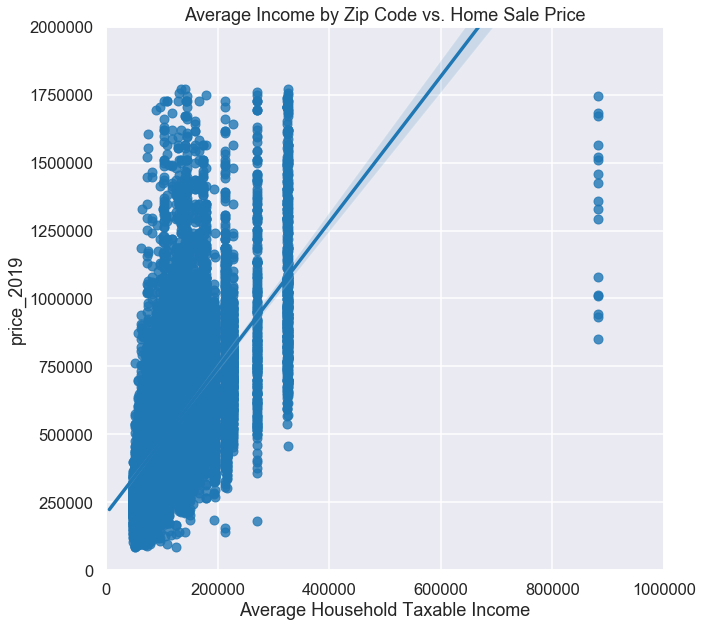

In [67]:
plt.figure(figsize=(10,10))
sns.regplot(x='Average Household Taxable Income', y='price_2019', data=kc_df_cleaned)
plt.xlim(0,1000000)
plt.ylim(0,2000000)
plt.title("Average Income by Zip Code vs. Home Sale Price")

More outliers here (about 17 of them), let's deal with these. Household in this area have a mean income significantly higher than the rest. This will screw up our min-max scaling later on. 

In [68]:
kc_df_cleaned['Average Household Taxable Income'].max()

881945.4545454546

In [69]:
sum(kc_df_cleaned['Average Household Taxable Income']==881945.4545454546)

17

In [70]:
kc_df_cleaned = kc_df_cleaned[kc_df_cleaned['Average Household Taxable Income'] != 881945.4545454546]
kc_df_cleaned.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,viewed,condition,grade,...,long,sqft_living15,sqft_lot15,year_sold,month_sold,season_sold,basement,price_2019,Zip Code,Average Household Taxable Income
0,7129300520,"(2, 3]","(0, 1]",1180,5650,1.0,0.0,0,3,4,...,-122.257,1340,5650,2014,10,Fall,0,239483.0,98178,62641.742424
1,4060000240,"(1, 2]","(0, 1]",880,6780,1.0,0.0,0,4,3,...,-122.248,1190,6780,2014,6,Summer,0,221702.0,98178,62641.742424
2,4058801670,"(2, 3]","(2, 3]",2100,8201,1.0,0.0,1,3,5,...,-122.244,2660,8712,2014,7,Summer,1,480261.0,98178,62641.742424
3,2976800796,"(2, 3]","(0, 1]",1300,5898,1.0,0.0,0,3,4,...,-122.255,1320,7619,2014,9,Fall,0,254700.0,98178,62641.742424
4,3969300030,"(3, 4]","(0, 1]",1000,7134,1.0,0.0,0,3,3,...,-122.240,1020,7138,2014,7,Summer,0,178074.0,98178,62641.742424


Text(0.5, 1.0, 'Average Income by Zip Code vs. Home Sale Price')

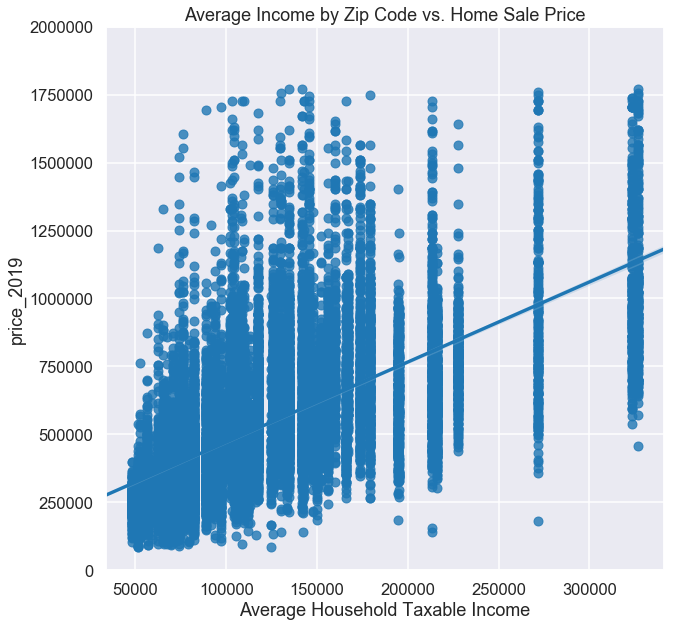

In [71]:
# let's plot it again and take a look, this is much better
plt.figure(figsize=(10,10))
sns.regplot(x='Average Household Taxable Income', y='price_2019', data=kc_df_cleaned)
plt.ylim(0,2000000)
plt.title("Average Income by Zip Code vs. Home Sale Price")

### One Hot Encoding

Time to turn our attention to our categorical variables which require one-hot encoding. The following variables will be one hot encoded. 

In [72]:
kc_df_cleaned.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'viewed', 'condition', 'grade', 'sqft_above', 'yr_built',
       'Renovated_since_1980', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year_sold', 'month_sold', 'season_sold', 'basement',
       'price_2019', 'Zip Code', 'Average Household Taxable Income'],
      dtype='object')

In [73]:
encode_these = ['bedrooms', 'bathrooms', 'condition', 'grade', 'floors', 'yr_built', 'season_sold']

In [74]:
# encode all variables to be encoded
bedroom_dummies = pd.get_dummies(kc_df_cleaned['bedrooms'], prefix='bedrooms', drop_first=True)
bathroom_dummies = pd.get_dummies(kc_df_cleaned['bathrooms'], prefix='bathrooms', drop_first=True)
condition_dummies = pd.get_dummies(kc_df_cleaned['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(kc_df_cleaned['grade'], prefix='grade', drop_first=True)
floors_dummies = pd.get_dummies(kc_df_cleaned['floors'], prefix='floors', drop_first=True)
yr_built_dummies = pd.get_dummies(kc_df_cleaned['yr_built'], prefix='yr_built', drop_first=True)
season_sold_dummies = pd.get_dummies(kc_df_cleaned['season_sold'], prefix='season_sold', drop_first=True)

In [75]:
# drop original categorical variables
kc_df_cleaned = kc_df_cleaned.drop(['bedrooms', 'bathrooms', 'condition', 'grade', 'floors', 'yr_built', 'season_sold'], axis=1)

In [76]:
# concat all relevant data into new dataframe
kc_df_encoded = pd.concat([kc_df_cleaned, bedroom_dummies, bathroom_dummies, condition_dummies, grade_dummies, floors_dummies, yr_built_dummies, season_sold_dummies],
                          axis=1)

kc_df_encoded.columns

Index(['id', 'sqft_living', 'sqft_lot', 'waterfront', 'viewed', 'sqft_above',
       'Renovated_since_1980', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'year_sold', 'month_sold', 'basement', 'price_2019',
       'Zip Code', 'Average Household Taxable Income', 'bedrooms_(1, 2]',
       'bedrooms_(2, 3]', 'bedrooms_(3, 4]', 'bedrooms_(4, 6]',
       'bathrooms_(1, 2]', 'bathrooms_(2, 3]', 'bathrooms_(3, 4]',
       'bathrooms_(4, 5]', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'floors_1.5', 'floors_2.0',
       'floors_2.5', 'floors_3.0', 'floors_3.5', 'yr_built_(1950, 1975]',
       'yr_built_(1975, 2000]', 'yr_built_(2000, 2015]', 'season_sold_Spring',
       'season_sold_Summer', 'season_sold_Winter'],
      dtype='object')

### Deal with Multicollinearity

We've making great progress with preparing our features for modeling but we still have some work to do. In this step we will check for multicollinearity and remove variables as necessary. We will use a correlation coefficient cutoff of 0.70 which is fairly industry standard. 

In [77]:
pd.set_option('display.max_columns', 500) # so all columns are shown
(abs(kc_df_encoded.corr()) > 0.7)

,id,sqft_living,sqft_lot,waterfront,viewed,sqft_above,Renovated_since_1980,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,basement,price_2019,Zip Code,Average Household Taxable Income,"bedrooms_(1, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 6]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 4]","bathrooms_(4, 5]",condition_2,condition_3,condition_4,condition_5,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,"yr_built_(1950, 1975]","yr_built_(1975, 2000]","yr_built_(2000, 2015]",season_sold_Spring,season_sold_Summer,season_sold_Winter
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
viewed,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_above,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Renovated_since_1980,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
zipcode,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Judging by this we have problems with multicollinearity between 'sqft_above' and 'sqft_living', 'sqft_lot15' and 'sqft_lot', and 'sqft_living15' and 'sqft_living'. 

We will remove 'sqft_living_15', 'sqft_lot_15', and 'sqft_above' below. 

In [78]:
kc_df_no_mc = kc_df_encoded.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'],axis=1)

In [79]:
kc_df_no_mc.columns

Index(['id', 'sqft_living', 'sqft_lot', 'waterfront', 'viewed',
       'Renovated_since_1980', 'zipcode', 'lat', 'long', 'year_sold',
       'month_sold', 'basement', 'price_2019', 'Zip Code',
       'Average Household Taxable Income', 'bedrooms_(1, 2]',
       'bedrooms_(2, 3]', 'bedrooms_(3, 4]', 'bedrooms_(4, 6]',
       'bathrooms_(1, 2]', 'bathrooms_(2, 3]', 'bathrooms_(3, 4]',
       'bathrooms_(4, 5]', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_1', 'grade_2', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'floors_1.5', 'floors_2.0',
       'floors_2.5', 'floors_3.0', 'floors_3.5', 'yr_built_(1950, 1975]',
       'yr_built_(1975, 2000]', 'yr_built_(2000, 2015]', 'season_sold_Spring',
       'season_sold_Summer', 'season_sold_Winter'],
      dtype='object')

### Using Logic to Eliminate Unhelpful Features

1. We no longer need the zipcode columns with our new proxy feature - these will be dropped. 
2. 'month_sold' not needed as we have season sold - this will be dropped. 
3. 'year_sold' not relevant as we are normalizing price to 2019 USD - dropped. 
4. 'id' is not relevant - dropped. 

In [80]:
kc_df_final_raw = kc_df_no_mc.drop(['Zip Code', 'zipcode', 'month_sold', 'year_sold', 'id'], axis=1)

So this is it below. Our final (pre-transformed, pre-normalzied) dataset that is ready for modeling. 

In [81]:
kc_df_final_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19747 entries, 0 to 19763
Data columns (total 42 columns):
sqft_living                         19747 non-null int64
sqft_lot                            19747 non-null int64
waterfront                          19747 non-null float64
viewed                              19747 non-null int64
Renovated_since_1980                19747 non-null int64
lat                                 19747 non-null float64
long                                19747 non-null float64
basement                            19747 non-null int64
price_2019                          19747 non-null float64
Average Household Taxable Income    19747 non-null float64
bedrooms_(1, 2]                     19747 non-null uint8
bedrooms_(2, 3]                     19747 non-null uint8
bedrooms_(3, 4]                     19747 non-null uint8
bedrooms_(4, 6]                     19747 non-null uint8
bathrooms_(1, 2]                    19747 non-null uint8
bathrooms_(2, 3]          

In [82]:
kc_df_final_raw.head()

,sqft_living,sqft_lot,waterfront,viewed,Renovated_since_1980,lat,long,basement,price_2019,Average Household Taxable Income,"bedrooms_(1, 2]","bedrooms_(2, 3]","bedrooms_(3, 4]","bedrooms_(4, 6]","bathrooms_(1, 2]","bathrooms_(2, 3]","bathrooms_(3, 4]","bathrooms_(4, 5]",condition_2,condition_3,condition_4,condition_5,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,"yr_built_(1950, 1975]","yr_built_(1975, 2000]","yr_built_(2000, 2015]",season_sold_Spring,season_sold_Summer,season_sold_Winter
0,1180,5650,0.0,0,0,47.5112,-122.257,0,239483.0,62641.742424,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,880,6780,0.0,0,0,47.5009,-122.248,0,221702.0,62641.742424,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2100,8201,0.0,1,0,47.5091,-122.244,1,480261.0,62641.742424,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1300,5898,0.0,0,0,47.5053,-122.255,0,254700.0,62641.742424,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1000,7134,0.0,0,0,47.4897,-122.240,0,178074.0,62641.742424,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Model #1 (Baseline) - Raw Data

In [83]:
# attempt to rename columns into Python friendly format - remove periods in column names
kc_df_final_raw = kc_df_final_raw.rename(columns={'floors_1.5': 'floors_15', 
                                                  'floors_2.0': 'floors_20',
                                                  'floors_2.5': 'floors_25',
                                                  'floors_3.0': 'floors_30',
                                                  'floors_3.5': 'floors_35',
                                                  'bathrooms_(1, 2]': 'bathrooms_2',
                                                  'bathrooms_(2, 3]': 'bathrooms_3',
                                                  'bathrooms_(3, 4]': 'bathrooms_4',
                                                  'bathrooms_(4, 5]': 'bathrooms_5',
                                                  'bedrooms_(1, 2]': 'bedrooms_2',
                                                  'bedrooms_(2, 3]': 'bedrooms_3',
                                                  'bedrooms_(3, 4]': 'bedrooms_4',
                                                  'bedrooms_(4, 6]': 'bedrooms_5_or_6',
                                                  'yr_built_(1950, 1975]': 'yr_built_1950_to_1975',
                                                  'yr_built_(1975, 2000]': 'yr_built_1975_to_2000',
                                                  'yr_built_(2000, 2015]': 'yr_built_2000_to_2015',
                                                  'Average Household Taxable Income': 'avg_income_by_zip'})

In [84]:
# rather than write out R style formula manually we will use the code below
outcome = 'price_2019'
predictors = kc_df_final_raw.drop('price_2019', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

### Model 1.0

In [85]:
# finally here is our model
model1_0 = ols(formula=formula, data=kc_df_final_raw).fit()
model1_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_2019   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1748.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:07:29   Log-Likelihood:            -2.5915e+05
No. Observations:               19747   AIC:                         5.184e+05
Df Residuals:                   19705   BIC:                         5.187e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -4.503e+07   1.11e+06    -40.433      0.000   -4.72e+07   -4.29e+07
sqft_living             112.3214      2.354     47.716      0.000     107.707     116.935
sqft_lot                 -0.2500      0.096     -2.604      0.009      -0.438      -0.062
waterfront             3.269e+05   1.53e+04     21.320      0.000    2.97e+05    3.57e+05
viewed                 1.039e+05   3416.282     30.417      0.000    9.72e+04    1.11e+05
Renovated_since_1980   5.793e+04   5528.059     10.479      0.000    4.71e+04    6.88e+04
lat                    3.009e+05   7353.906     40.922      0.000    2.87e+05    3.15e+05
long                  -2.523e+05   8949.750    -28.189      0.000    -2.7e+05   -2.35e+05
basement               2984.3177   2219.031      1.345      0.179   -1365.170    7333.805
avg_income_by_zip         1.8217      0.019     93.918      0.000       1.784       1.860
bedrooms_2             4736.4485   9479.593      0.500      0.617   -1.38e+04    2.33e+04
bedrooms_3             8834.0387   9525.031      0.927      0.354   -9835.827    2.75e+04
bedrooms_4             -308.7607   9762.038     -0.032      0.975   -1.94e+04    1.88e+04
bedrooms_5_or_6       -5426.3838   1.03e+04     -0.527      0.598   -2.56e+04    1.48e+04
bathrooms_2            6708.4586   3046.678      2.202      0.028     736.713    1.27e+04
bathrooms_3            2.248e+04   3965.894      5.668      0.000    1.47e+04    3.03e+04
bathrooms_4            7.843e+04   6022.436     13.023      0.000    6.66e+04    9.02e+04
bathrooms_5            1.183e+05   2.64e+04      4.477      0.000    6.65e+04     1.7e+05
condition_2            2.758e+04   2.51e+04      1.101      0.271   -2.15e+04    7.67e+04
condition_3            5.277e+04   2.32e+04      2.278      0.023    7369.749    9.82e+04
condition_4            7.953e+04   2.32e+04      3.432      0.001    3.41e+04    1.25e+05
condition_5            1.225e+05   2.33e+04      5.255      0.000    7.68e+04    1.68e+05
grade_1               -1.848e+05   1.24e+05     -1.494      0.135   -4.27e+05    5.76e+04
grade_2               -1.913e+05   1.22e+05     -1.570      0.117    -4.3e+05    4.76e+04
grade_3               -1.692e+05   1.22e+05     -1.391      0.164   -4.08e+05    6.93e+04
grade_4               -1.121e+05   1.22e+05     -0.921      0.357   -3.51e+05    1.27e+05
grade_5               -5.189e+04   1.22e+05     -0.426      0.670   -2.91e+05    1.87e+05
grade_6                5.932e+04   1.22e+05      0.487      0.626   -1.79e+05    2.98e+05
grade_7                1.452e+05   1.22e+05      1.191      0.234   -9.37e+04    3.84e+05
grade_8                2.496e+05   1.23e+05      2.037      0.042    9402.043     4.9e+05
grade_9                2.687e+05   1.72e+05      1.562      0.118   -6.86e+04    6.06e+05
floors_15              

### Model 1.1

Woah! Quite a few of our variables have p-values over 0.05 (our cutoff) and several are very surprising such as bedrooms and grade of home. We'll condense a list of our variables that made the cutoff below. 

In [86]:
kc_df_final_pval_variables = ['price_2019', 'sqft_living', 'sqft_lot', 'waterfront', 'viewed', 'Renovated_since_1980', 
                              'lat', 'long', 'avg_income_by_zip', 'bathrooms_2', 'bathrooms_3', 'bathrooms_4', 
                              'bathrooms_5', 'condition_3', 'condition_4', 'condition_5', 'grade_8', 'floors_15', 
                              'floors_20', 'floors_25', 'floors_30', 'floors_35', 'yr_built_1950_to_1975', 
                              'yr_built_1975_to_2000', 'yr_built_2000_to_2015', 'season_sold_Spring']

In [87]:
kc_df_final_1_1 = kc_df_final_raw[kc_df_final_pval_variables]

Now we will take a look at a new model with those variables removed. 

In [88]:
# rather than write out R style formula manually we will use the code below
outcome = 'price_2019'
predictors_1_1 = kc_df_final_1_1.drop('price_2019', axis=1)
pred_sum_1_1 = '+'.join(predictors_1_1.columns)
formula_1_1 = outcome + '~' + pred_sum_1_1

In [89]:
model1_1 = ols(formula=formula_1_1, data=kc_df_final_1_1).fit()
model1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_2019   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     2361.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:07:30   Log-Likelihood:            -2.6062e+05
No. Observations:               19747   AIC:                         5.213e+05
Df Residuals:                   19721   BIC:                         5.215e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -5.31e+07   1.13e+06    -46.990      0.000   -5.53e+07   -5.09e+07
sqft_living             163.1679      1.940     84.110      0.000     159.365     166.970
sqft_lot                  0.0196      0.103      0.191      0.849      -0.182       0.221
waterfront             3.264e+05   1.65e+04     19.797      0.000    2.94e+05    3.59e+05
viewed                 1.224e+05   3634.286     33.678      0.000    1.15e+05     1.3e+05
Renovated_since_1980   6.413e+04   5943.033     10.791      0.000    5.25e+04    7.58e+04
lat                    3.153e+05   7840.917     40.207      0.000       3e+05    3.31e+05
long                  -3.109e+05   9224.459    -33.707      0.000   -3.29e+05   -2.93e+05
avg_income_by_zip         2.0851      0.020    103.245      0.000       2.046       2.125
bathrooms_2             867.1335   3038.987      0.285      0.775   -5089.537    6823.804
bathrooms_3            1.609e+04   3967.002      4.056      0.000    8314.637    2.39e+04
bathrooms_4            8.203e+04   6215.665     13.198      0.000    6.99e+04    9.42e+04
bathrooms_5            1.202e+05   2.84e+04      4.233      0.000    6.45e+04    1.76e+05
condition_3            4.568e+04   9976.808      4.578      0.000    2.61e+04    6.52e+04
condition_4            6.825e+04      1e+04      6.810      0.000    4.86e+04    8.79e+04
condition_5            1.094e+05   1.04e+04     10.504      0.000     8.9e+04     1.3e+05
grade_8                1.877e+05    1.4e+04     13.433      0.000     1.6e+05    2.15e+05
floors_15               2.61e+04   3644.265      7.162      0.000     1.9e+04    3.32e+04
floors_20              3.259e+04   2953.976     11.031      0.000    2.68e+04    3.84e+04
floors_25              1.019e+05   1.23e+04      8.289      0.000    7.78e+04    1.26e+05
floors_30              5.548e+04   6470.593      8.575      0.000    4.28e+04    6.82e+04
floors_35              6.589e+04   5.35e+04      1.233      0.218   -3.89e+04    1.71e+05
yr_built_1950_to_1975 -5.316e+04   2962.425    -17.943      0.000    -5.9e+04   -4.73e+04
yr_built_1975_to_2000 -6.171e+04   3679.092    -16.772      0.000   -6.89e+04   -5.45e+04
yr_built_2000_to_2015 -5.086e+04   4375.545    -11.623      0.000   -5.94e+04   -4.23e+04
season_sold_Spring     2.361e+04   2027.848     11.642      0.000    1.96e+04    2.76e+04
==============================================================================
Omnibus:                     4393.866   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20465.787
Skew:                           1.011   Prob(JB):                         0.00
Kurtosis:                       7.559   Cond. No.                     1.61e+08
==============================================================================

Our R_squared_adjusted went down slightly, however, we were able to get rid of a lot of features which will help prevent overfitting. 

## Model #2 - Transform, Scale, and Normalize Data

Let's take another look at the distributions of our continuous variables. 

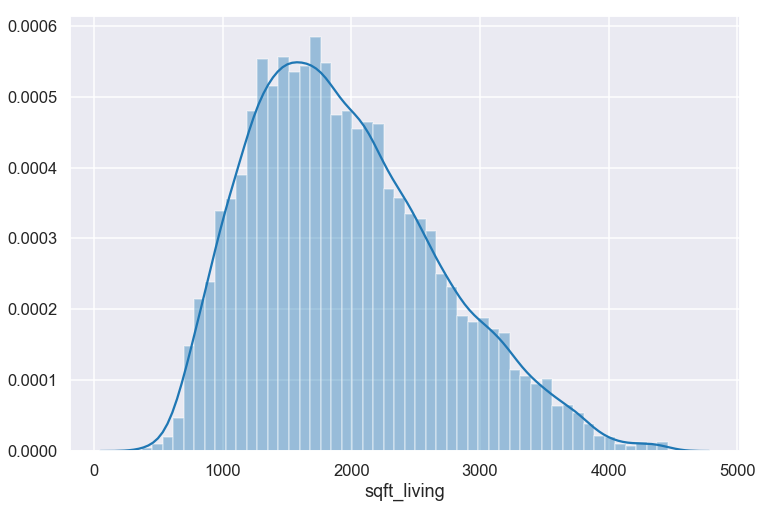

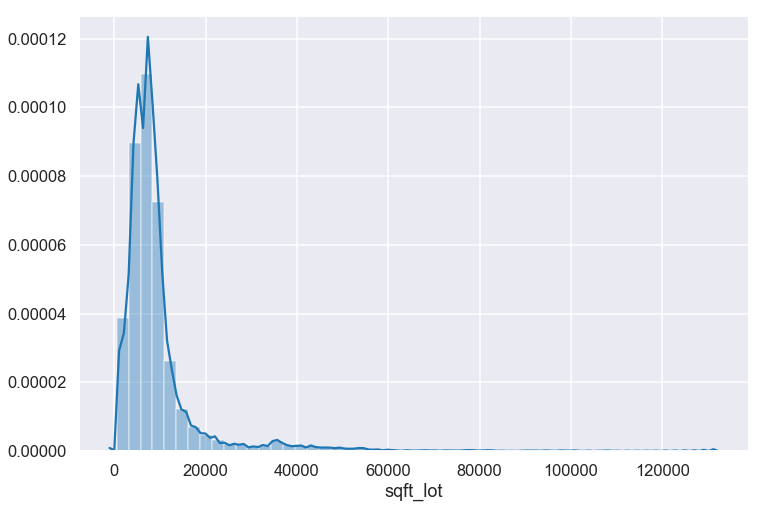

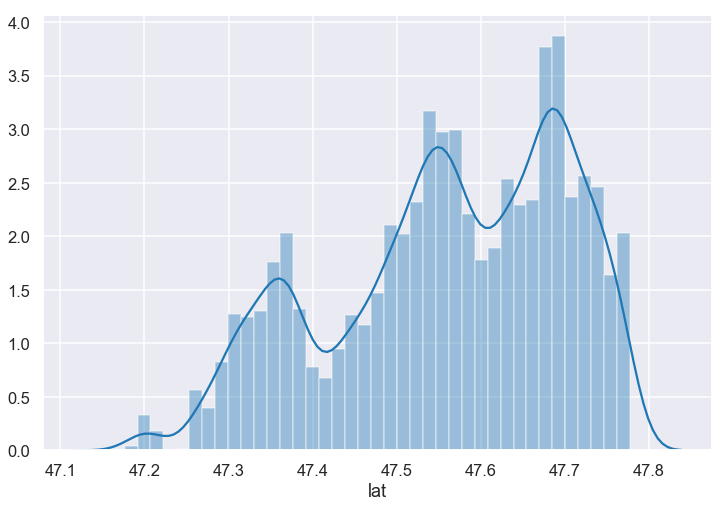

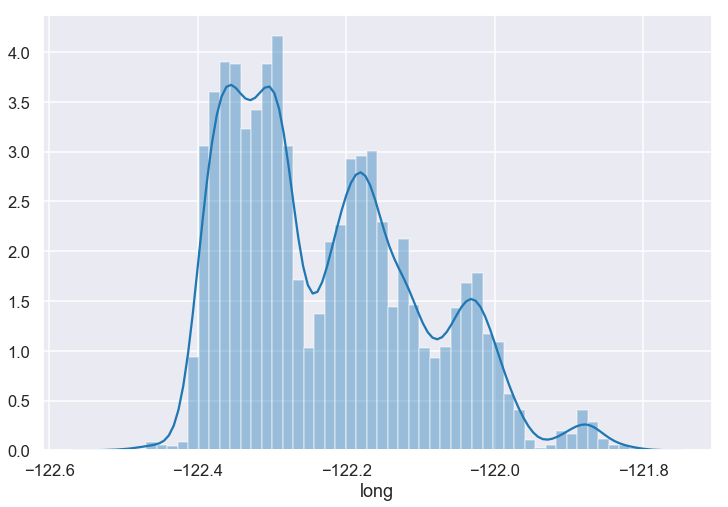

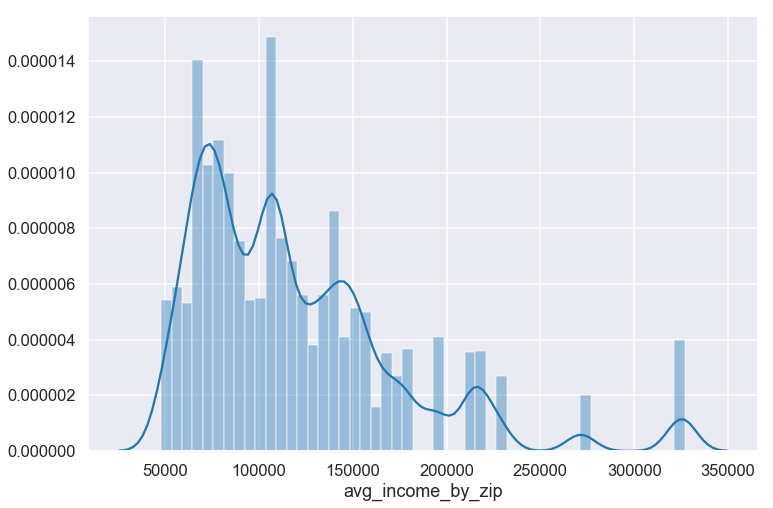

In [90]:
continuous_variables = ['sqft_living', 'sqft_lot', 'lat', 'long', 'avg_income_by_zip']

for var in continuous_variables:
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    sns.distplot(kc_df_final_1_1[var])

Let's see if a log transformation make them more normal. 

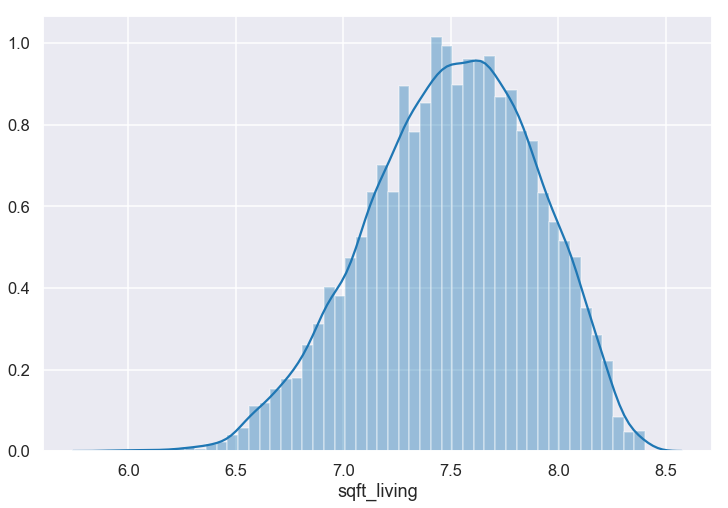

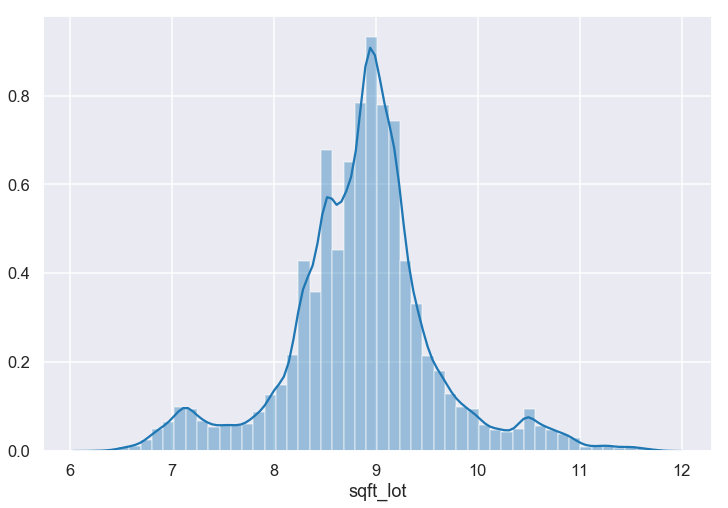

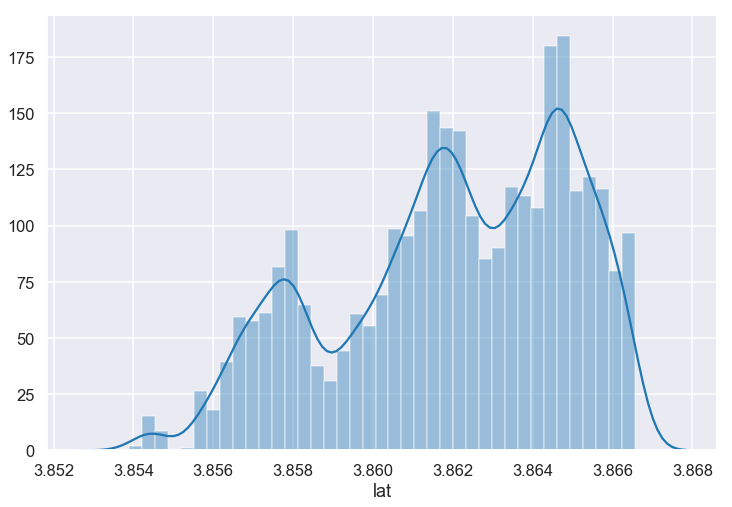

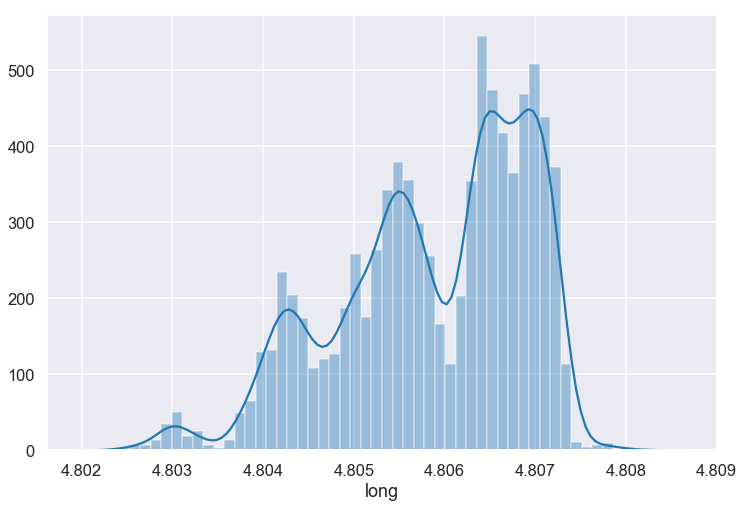

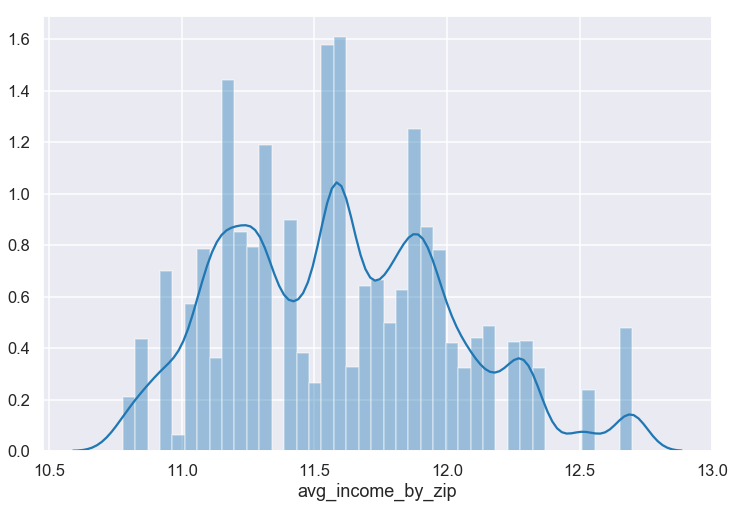

In [91]:
# log transformed
for var in continuous_variables:
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    sns.distplot(np.log(abs(kc_df_final_1_1[var])), hist=True)

Let's create a new dataframe where all of our continuous data is normalized. 

In [92]:
# initialize new dataframe
kc_df_final_2_0 = pd.DataFrame([])

# let's carry on with the log transform of all variables
kc_df_final_2_0['log_sqft_living'] = np.log(kc_df_final_1_1['sqft_living'])
kc_df_final_2_0['log_sqft_lot'] = np.log(kc_df_final_1_1['sqft_lot'])
kc_df_final_2_0['log_lat'] = np.log(kc_df_final_1_1['lat'])
kc_df_final_2_0['log_long'] = np.log(abs(kc_df_final_1_1['long'])) # use absolute value
kc_df_final_2_0['log_avg_income'] = np.log(kc_df_final_1_1['avg_income_by_zip'])
kc_df_final_2_0['log_price_2019'] = np.log(kc_df_final_1_1['price_2019'])

# concat with original dataframe 
kc_df_final_2_0 = pd.concat([kc_df_final_1_1, kc_df_final_2_0], axis=1)

# and drop non-log continuous values
kc_df_final_2_0 = kc_df_final_2_0.drop(['sqft_living', 'sqft_lot', 'lat', 'long', 'avg_income_by_zip', 'price_2019'], axis=1)

kc_df_final_2_0

,waterfront,viewed,Renovated_since_1980,bathrooms_2,bathrooms_3,bathrooms_4,bathrooms_5,condition_3,condition_4,condition_5,grade_8,floors_15,floors_20,floors_25,floors_30,floors_35,yr_built_1950_to_1975,yr_built_1975_to_2000,yr_built_2000_to_2015,season_sold_Spring,log_sqft_living,log_sqft_lot,log_lat,log_long,log_avg_income,log_price_2019
0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,7.073270,8.639411,3.860965,4.806125,11.045187,12.386238
1,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.779922,8.821732,3.860749,4.806052,11.045187,12.309089
2,0.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,7.649693,9.012011,3.860921,4.806019,11.045187,13.082085
3,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,7.170120,8.682369,3.860841,4.806109,11.045187,12.447842
4,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6.907755,8.872627,3.860513,4.805986,11.045187,12.089954
5,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6.907755,8.872627,3.860513,4.805986,11.045187,12.464232
6,0.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,7.383989,9.775654,3.860424,4.806199,11.045187,12.656989
7,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6.445720,8.699515,3.860673,4.805831,11.045187,12.231034
8,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,7.073270,8.584852,3.860835,4.806142,11.045187,12.544693
9,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.866933,8.764053,3.860645,4.805978,11.045187,12.652165


### Model 2.0

In [93]:
outcome = 'log_price_2019'
predictors_2_0 = kc_df_final_2_0.drop('log_price_2019', axis=1)
pred_sum_2_0 = '+'.join(predictors_2_0.columns)
pred_sum_2_0
formula_2_0 = outcome + '~' + pred_sum_2_0

In [94]:
model2_0 = ols(formula=formula_2_0, data=kc_df_final_2_0).fit()
model2_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_price_2019   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2978.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:07:32   Log-Likelihood:                 2330.0
No. Observations:               19747   AIC:                            -4608.
Df Residuals:                   19721   BIC:                            -4403.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -467.0183      9.276    -50.348      0.000    -485.200    -448.837
waterfront                0.4491      0.027     16.511      0.000       0.396       0.502
viewed                    0.1870      0.006     31.285      0.000       0.175       0.199
Renovated_since_1980      0.0895      0.010      9.142      0.000       0.070       0.109
bathrooms_2               0.0029      0.005      0.551      0.582      -0.007       0.013
bathrooms_3               0.0394      0.007      5.663      0.000       0.026       0.053
bathrooms_4               0.1144      0.010     11.033      0.000       0.094       0.135
bathrooms_5               0.1363      0.047      2.918      0.004       0.045       0.228
condition_3               0.1726      0.016     10.488      0.000       0.140       0.205
condition_4               0.2152      0.017     13.018      0.000       0.183       0.248
condition_5               0.2743      0.017     15.959      0.000       0.241       0.308
grade_8                   0.1835      0.023      7.993      0.000       0.139       0.229
floors_15                 0.0345      0.006      5.690      0.000       0.023       0.046
floors_20                 0.0494      0.005      9.986      0.000       0.040       0.059
floors_25                 0.1110      0.020      5.454      0.000       0.071       0.151
floors_30                 0.0674      0.011      6.147      0.000       0.046       0.089
floors_35                 0.1210      0.088      1.373      0.170      -0.052       0.294
yr_built_1950_to_1975    -0.1004      0.005    -20.418      0.000      -0.110      -0.091
yr_built_1975_to_2000    -0.0969      0.006    -15.974      0.000      -0.109      -0.085
yr_built_2000_to_2015    -0.0559      0.007     -7.588      0.000      -0.070      -0.041
season_sold_Spring        0.0447      0.003     13.383      0.000       0.038       0.051
log_sqft_living           0.5539      0.007     83.684      0.000       0.541       0.567
log_sqft_lot              0.0045      0.003      1.488      0.137      -0.001       0.010
log_lat                  33.7951      0.661     51.094      0.000      32.499      35.092
log_long                 70.5744      1.964     35.943      0.000      66.726      74.423
log_avg_income            0.5169      0.005    108.441      0.000       0.508       0.526
==============================================================================
Omnibus:                      564.594   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1331.800
Skew:                          -0.120   Prob(JB):                    6.36e-290
Kurtosis:                       4.249   Cond. No.                     1.09e+05
==============================================================================

Slight improvement - we will also min-max normalize these variables in the next step and see if it helps. 

### Model 2.1

Let's now normalize our log-transformed, continuous variables and see if we can improve our model. 

In [95]:
# let's initialize our new dataframe and normalize everything
kc_df_final_2_1 = kc_df_final_2_0
kc_df_final_2_0.head()

# first we need to drop the columns with p-values over 0.05
kc_df_final_2_1 = kc_df_final_2_1.drop(['log_sqft_lot', 'floors_35', 'bathrooms_2'], axis=1)

In [96]:
len(kc_df_final_2_1)

19747

In [97]:
# normalize variables using min-max scaling
kc_df_final_2_1['norm_sqft_living'] = (kc_df_final_2_0['log_sqft_living'] - min(kc_df_final_2_0['log_sqft_living'])) / (max(kc_df_final_2_0['log_sqft_living']) - min(kc_df_final_2_0['log_sqft_living']))
#kc_df_final_2_1['norm_sqft_lot'] = (kc_df_final_2_0['log_sqft_lot'] - min(kc_df_final_2_0['log_sqft_lot'])) / (max(kc_df_final_2_0['log_sqft_lot']) - min(kc_df_final_2_0['log_sqft_lot']))
kc_df_final_2_1['norm_lat'] = (kc_df_final_2_0['log_lat'] - min(kc_df_final_2_0['log_lat'])) / (max(kc_df_final_2_0['log_lat']) - min(kc_df_final_2_0['log_lat']))
kc_df_final_2_1['norm_long'] = (kc_df_final_2_0['log_long'] - min(kc_df_final_2_0['log_long'])) / (max(kc_df_final_2_0['log_long']) - min(kc_df_final_2_0['log_long']))
kc_df_final_2_1['norm_avg_income'] = (kc_df_final_2_0['log_avg_income'] - min(kc_df_final_2_0['log_avg_income'])) / (max(kc_df_final_2_0['log_avg_income']) - min(kc_df_final_2_0['log_avg_income']))
#kc_df_final_2_1['norm_price_2019'] = (kc_df_final_2_0['log_price_2019'] - min(kc_df_final_2_0['log_price_2019'])) / (max(kc_df_final_2_0['log_price_2019']) - min(kc_df_final_2_0['log_price_2019']))

# and drop the log columns
kc_df_final_2_1 = kc_df_final_2_1.drop(['log_sqft_living', 'log_lat', 'log_long', 'log_avg_income'], axis=1)

In [98]:
# write out formula
outcome = 'log_price_2019'
predictors_2_1 = kc_df_final_2_1.drop('log_price_2019', axis=1)
pred_sum_2_1 = '+'.join(predictors_2_1.columns)
formula_2_1 = outcome + '~' + pred_sum_2_1

In [99]:
# fit model
model2_1 = ols(formula=formula_2_1, data=kc_df_final_2_1).fit()
model2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_price_2019   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     3384.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:07:32   Log-Likelihood:                 2328.0
No. Observations:               19747   AIC:                            -4610.
Df Residuals:                   19724   BIC:                            -4428.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                11.0384      0.019    567.511      0.000      11.000      11.077
waterfront                0.4522      0.027     16.674      0.000       0.399       0.505
viewed                    0.1872      0.006     31.326      0.000       0.175       0.199
Renovated_since_1980      0.0897      0.010      9.198      0.000       0.071       0.109
bathrooms_3               0.0364      0.005      7.831      0.000       0.027       0.046
bathrooms_4               0.1109      0.009     13.030      0.000       0.094       0.128
bathrooms_5               0.1332      0.046      2.879      0.004       0.043       0.224
condition_3               0.1711      0.016     10.423      0.000       0.139       0.203
condition_4               0.2140      0.016     12.974      0.000       0.182       0.246
condition_5               0.2727      0.017     15.941      0.000       0.239       0.306
grade_8                   0.1846      0.023      8.051      0.000       0.140       0.229
floors_15                 0.0336      0.006      5.559      0.000       0.022       0.045
floors_20                 0.0477      0.005      9.838      0.000       0.038       0.057
floors_25                 0.1080      0.020      5.330      0.000       0.068       0.148
floors_30                 0.0633      0.011      5.960      0.000       0.042       0.084
yr_built_1950_to_1975    -0.0994      0.005    -20.575      0.000      -0.109      -0.090
yr_built_1975_to_2000    -0.0954      0.006    -16.360      0.000      -0.107      -0.084
yr_built_2000_to_2015    -0.0574      0.007     -8.212      0.000      -0.071      -0.044
season_sold_Spring        0.0446      0.003     13.351      0.000       0.038       0.051
norm_sqft_living          1.3901      0.014    101.500      0.000       1.363       1.417
norm_lat                  0.4274      0.008     51.104      0.000       0.411       0.444
norm_long                 0.4042      0.011     37.565      0.000       0.383       0.425
norm_avg_income           0.9923      0.009    108.686      0.000       0.974       1.010
==============================================================================
Omnibus:                      562.188   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1328.433
Skew:                          -0.118   Prob(JB):                    3.42e-289
Kurtosis:                       4.249   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model #3 (Final) - Feature Selection

In [100]:
kc_df_final_3_0 = kc_df_final_2_1

### Model 3.0

Finally, we will utilize Scikit Learn's Recursive Feature Elimination (RFE) tool to determine the most important x features by looping through having 1 to 23 total features. 

In [101]:
# separate the predictors and the target
X = kc_df_final_3_0.drop('log_price_2019', axis=1)
y = kc_df_final_3_0['log_price_2019']

#initialize list to add r_adj values
r_squared_adj_list = []
    
for i in range(len(X.columns)):
    print("Pick {} features".format(i+1))
    # initialize linear regression object
    linreg = LinearRegression() 
    selector = RFE(linreg, n_features_to_select=(i+1)) 
    
    # convert y to 1d np array to prevent DataConversionWarning
    selector = selector.fit(X, y.values.ravel()) 
    
    # create list of selected columns
    selected_columns = X.columns[selector.support_ ]
    
    # fit linear regression model
    linreg.fit(X[selected_columns],y) 
    LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
    
    # predict y_hat values
    yhat = linreg.predict(X[selected_columns]) 
    
    # calculate performance metrics
    SS_Residual = np.sum((y-yhat)**2) # calculate SS residual
    SS_Total = np.sum((y-np.mean(y))**2) # calculate SS total
    r_squared = 1 - (float(SS_Residual))/SS_Total # calculate r_squared
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1) # calculate adjusted r_squared
    print(adjusted_r_squared)
    r_squared_adj_list.append(adjusted_r_squared)

Pick 1 features
0.36520896685256177
Pick 2 features
0.6593539469397888
Pick 3 features
0.7253536646495198
Pick 4 features
0.7304425373694374
Pick 5 features
0.7581756809043806
Pick 6 features
0.769361466406077
Pick 7 features
0.7700489136026705
Pick 8 features
0.7723881789441674
Pick 9 features
0.7726023527862083
Pick 10 features
0.7737691913435829
Pick 11 features
0.7753275008719898
Pick 12 features
0.7756600740429412
Pick 13 features
0.7757002837270993
Pick 14 features
0.7776824273080569
Pick 15 features
0.7830538225645992
Pick 16 features
0.7859492006736003
Pick 17 features
0.7859853799059563
Pick 18 features
0.7860913212054337
Pick 19 features
0.7874674298550597
Pick 20 features
0.7893641882457714
Pick 21 features
0.7900118408636225
Pick 22 features
0.7903297275489521


Let's now plot this and interpret our results. 

Text(0, 0.5, 'R-Squared Adjusted')

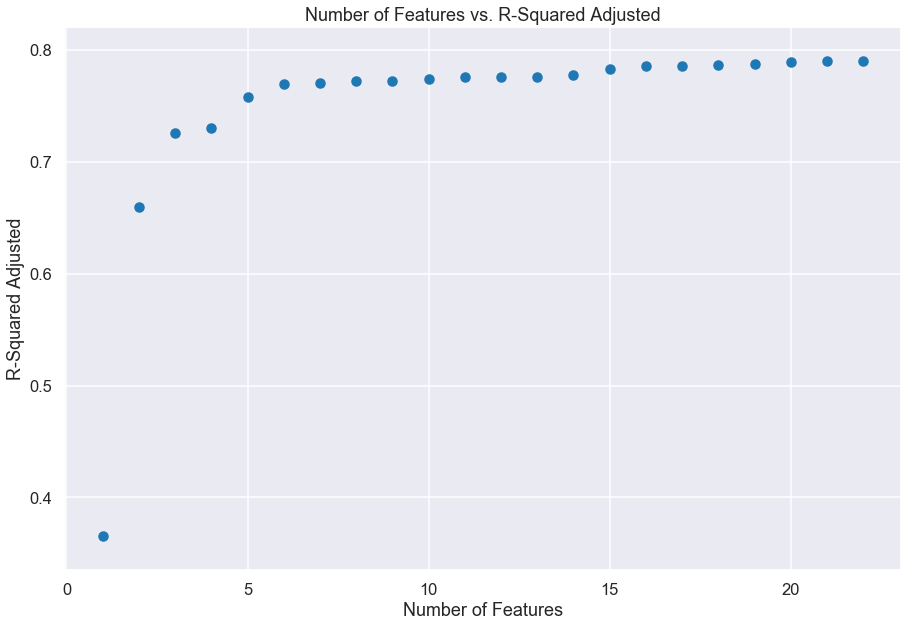

In [102]:
# plot r_squared adjusted against # of features
fig, ax = plt.subplots(1,1,figsize=(15,10))
x=np.array(range(1,23))
y2=r_squared_adj_list
plt.scatter(x,y2)
plt.title("Number of Features vs. R-Squared Adjusted")
plt.xlabel("Number of Features")
plt.ylabel("R-Squared Adjusted")

In [103]:
# the above graph and our results show that six variables can explain 77% of the variables in our modelet's see what 
# the top 6 variables are

# initialize linear regression object
linreg = LinearRegression() 
selector = RFE(linreg, n_features_to_select=(6)) 
 
# convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X, y.values.ravel()) 
    
# create list of selected columns
selected_columns = X.columns[selector.support_ ]
selected_columns

Index(['waterfront', 'viewed', 'norm_sqft_living', 'norm_lat', 'norm_long',
       'norm_avg_income'],
      dtype='object')

It appears that our r_squared_adjusted on our model only improves as we add more features to the model. Therefore, we are going to leave all features in our final model as represented by variable 'kc_df_final_3_0'. Interesting to note, however, we can expalin the same amount of variance in our model using just 15 variables as we can with 23. Furthermore, we can explain 77% of the variance with just the top six variables!

In [104]:
# write out formula
outcome = 'log_price_2019'
predictors_3_0 = kc_df_final_3_0.drop('log_price_2019', axis=1)
pred_sum_3_0 = '+'.join(predictors_3_0.columns)
formula_3_0 = outcome + '~' + pred_sum_3_0

In [105]:
# fit model
model3_0 = ols(formula=formula_3_0, data=kc_df_final_3_0).fit()
model3_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_price_2019   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     3384.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:07:34   Log-Likelihood:                 2328.0
No. Observations:               19747   AIC:                            -4610.
Df Residuals:                   19724   BIC:                            -4428.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                11.0384      0.019    567.511      0.000      11.000      11.077
waterfront                0.4522      0.027     16.674      0.000       0.399       0.505
viewed                    0.1872      0.006     31.326      0.000       0.175       0.199
Renovated_since_1980      0.0897      0.010      9.198      0.000       0.071       0.109
bathrooms_3               0.0364      0.005      7.831      0.000       0.027       0.046
bathrooms_4               0.1109      0.009     13.030      0.000       0.094       0.128
bathrooms_5               0.1332      0.046      2.879      0.004       0.043       0.224
condition_3               0.1711      0.016     10.423      0.000       0.139       0.203
condition_4               0.2140      0.016     12.974      0.000       0.182       0.246
condition_5               0.2727      0.017     15.941      0.000       0.239       0.306
grade_8                   0.1846      0.023      8.051      0.000       0.140       0.229
floors_15                 0.0336      0.006      5.559      0.000       0.022       0.045
floors_20                 0.0477      0.005      9.838      0.000       0.038       0.057
floors_25                 0.1080      0.020      5.330      0.000       0.068       0.148
floors_30                 0.0633      0.011      5.960      0.000       0.042       0.084
yr_built_1950_to_1975    -0.0994      0.005    -20.575      0.000      -0.109      -0.090
yr_built_1975_to_2000    -0.0954      0.006    -16.360      0.000      -0.107      -0.084
yr_built_2000_to_2015    -0.0574      0.007     -8.212      0.000      -0.071      -0.044
season_sold_Spring        0.0446      0.003     13.351      0.000       0.038       0.051
norm_sqft_living          1.3901      0.014    101.500      0.000       1.363       1.417
norm_lat                  0.4274      0.008     51.104      0.000       0.411       0.444
norm_long                 0.4042      0.011     37.565      0.000       0.383       0.425
norm_avg_income           0.9923      0.009    108.686      0.000       0.974       1.010
==============================================================================
Omnibus:                      562.188   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1328.433
Skew:                          -0.118   Prob(JB):                    3.42e-289
Kurtosis:                       4.249   Cond. No.                         57.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cross Validation and Model Diagnostics

### Check for Overfitting

First we want to make sure our model is not overfitting by training our model on a test set, analyzing the RMSE, and comparing it to the RMSE on the test data. 

In [106]:
# first we will split our dataset into train and test, setting random state variable for repeatability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# train model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# make predictions
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate residuals in log units
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print('Train Root Mean Squarred Error (log units):', train_rmse)
print('Test Root Mean Squarred Error (log units):', test_rmse)

# undo log transform on predictions for familiar units
y_hat_train = np.exp(y_hat_train)
y_hat_test = np.exp(y_hat_test)

# now undo log transform actual y values
y_train = np.exp(y_train)
y_test = np.exp(y_test)

# calculate residuals
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))
print('Train Root Mean Squarred Error:', train_rmse)
print('Test Root Mean Squarred Error:', test_rmse)

Train Root Mean Squarred Error (log units): 0.21628184794233268
Test Root Mean Squarred Error (log units): 0.210392734593875
Train Root Mean Squarred Error: 128158.1638738697
Test Root Mean Squarred Error: 126583.42470162606


We can now see that there is not a drastic distance between the two data sets so we don't need to worry about overfitting for now. 

### Analyzing Top Three Variables

We will now quantify the effect of tweaking the top three variables from our model. Because the min-max scaling had no effect on our model with the log transformed values, we will simply use model 2.0 for this analysis. Interpreting coefficients for log transformed variables can be a bit tricky, however, using the formulas described in the following links simplified the process. 

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/

https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/

In [108]:
top_three_features = ['waterfront', 'viewed', 'log_sqft_living']

First we'll look at 'waterfront'. 

In [127]:
waterfront_coeff = 0.4471
# increase in value (percent) by going from non-waterfront to waterfront property
waterfront_upgrade = round((np.exp(waterfront_coeff) - 1)*100, 2)
print("Ceteris paribus, the effect of a house being waterfront will increase home sale price by about {}%".format(waterfront_upgrade))

Ceteris paribus, the effect of a house being waterfront will increase home sale price by about 56.38%


Next, look at 'viewed'.

In [128]:
viewed_coeff = 0.1873
viewed_upgrade = round((np.exp(viewed_coeff) - 1)*100, 2)
print("Ceteris paribus, the effect of a house being previously viewed will increase home sale price by about {}%".format(viewed_upgrade))

Ceteris paribus, the effect of a house being previously viewed will increase home sale price by about 20.6%


Finally, we'll look at 'log_sqft_living'. 

In [129]:
log_sqft_living_coeff = 0.5539
sqft_living_upgrade = round(((1.1**log_sqft_living_coeff - 1) * 100), 2) # 10% increase in living space
print("Ceteris paribus, the effect of a 10% increase in living space will increase home sale price by about {}%".format(sqft_living_upgrade))

Ceteris paribus, the effect of a 10% increase in living space will increase home sale price by about 5.42%


### Cross Validation

In [135]:
cross_validation_5 = KFold(5, shuffle=True)
cross_validation_10 = KFold(5, shuffle=True)
cross_validation_20 = KFold(5, shuffle=True)

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=cross_validation_5,  scoring='r2'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=cross_validation_10, scoring='r2'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=cross_validation_20, scoring='r2'))

In [136]:
cv_5_results

0.789909506116222

In [138]:
cv_10_results

0.7898521015196189

In [137]:
cv_20_results

0.7897074440106583

### Linear Model Assumptions Check

#### Checking for Normality

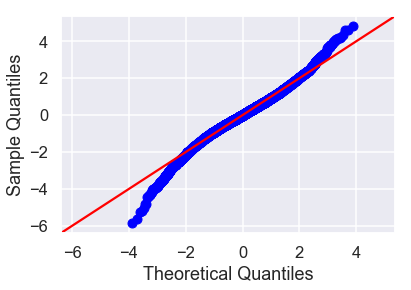

In [116]:
fig = sm.graphics.qqplot(model3_0.resid, dist=stats.norm, line='45', fit=True)

(array([  1.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   2.,   0.,
          0.,   0.,   2.,   2.,   3.,   1.,   6.,   6.,   4.,  10.,   8.,
          9.,   7.,  17.,  11.,  14.,  21.,  28.,  35.,  39.,  47.,  58.,
         51.,  77.,  65., 111., 122., 141., 176., 206., 231., 269., 324.,
        355., 505., 499., 627., 637., 757., 843., 898., 943., 957., 931.,
        898., 870., 933., 835., 806., 732., 681., 558., 527., 445., 428.,
        319., 255., 238., 197., 166., 156., 118.,  89.,  81.,  76.,  65.,
         31.,  33.,  25.,  17.,  12.,  20.,  16.,  13.,  11.,   5.,   3.,
          2.,   5.,   6.,   2.,   3.,   5.,   1.,   1.,   0.,   2.,   0.,
          1.]),
 array([-1.26123589, -1.23822097, -1.21520605, -1.19219113, -1.16917621,
        -1.14616129, -1.12314637, -1.10013145, -1.07711653, -1.05410161,
        -1.03108669, -1.00807177, -0.98505685, -0.96204193, -0.93902701,
        -0.91601209, -0.89299717, -0.86998225, -0.84696733, -0.82395241,
        -0.80093749, -0.77

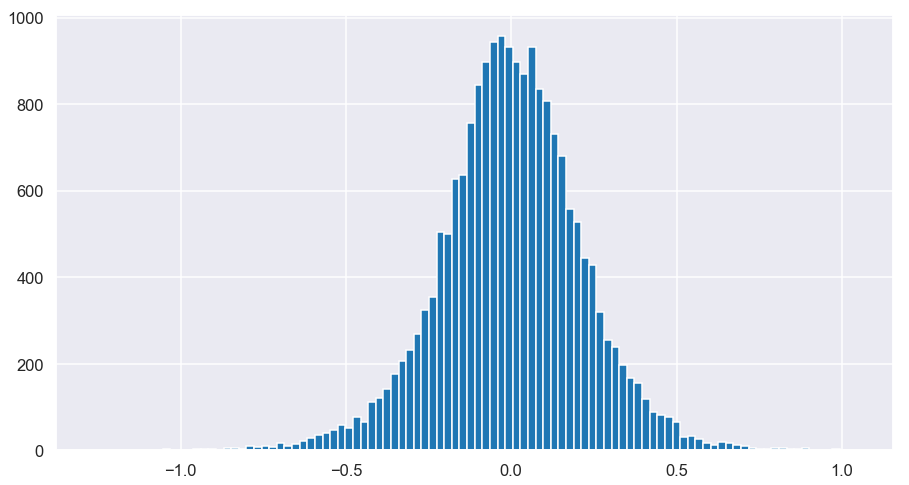

In [117]:
plt.figure(figsize=(15,8))
plt.hist(model3_0.resid, bins=100)

It is certainly not a perfect distribution with it's slight left skew, however, the non-normality is not alarming. 

#### Checking for Homoskedasticity

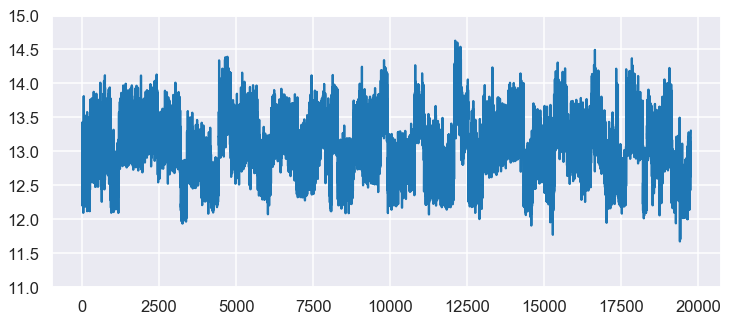

In [118]:
plt.figure(figsize=(12,5))
plt.scatter(model3_0.predict(X), model3_0.resid)
plt.ylim(11,15)
plt.plot(model3_0.predict(X, [0 for i in range(len(X))]))

Homoskedasticity checks out okay. 

## Final Model Analysis

In summary I am somewhat pleased with our final model though there are clearly unseen factors at play here which contribute to home valuation. 

**The good**
1. Our final model has an r-squared-adjusted value of 0.79 and utilizes 22 features. Furthermore, using only the top 6 features, our model has an r-squared-adjusted value of 0.77 which means that we may explain 77% of the variance in home prices in the King County area using just those six features which is quite impressive. 
2. Our model performs more or less equally well with both test and train datasets implying we have certainly not overfit our model. 
3. Normality and homoskedasticity are both acceptable for residuals. 

**The bad**
1. Our RMSE is 127k USD! This is not very confidence inspiring considering that the median home value of our analyzed dataset is 472k USD. 
2. We eliminated quite a bit of outliers to create a model capable of performing well with our remaining dataset. Our final, trimmed dataset contained only 91% of the original values and our model's accuracy is only proven below the 1.8MM USD price point.  

# Business Recommendations and Further Studies

## Business Recommendations

Business recommendations may be summarized as follows. 

1. Buy properties in the winter time when market is not as hot. The worst times to buy a home include late Spring and early Summer. 
2. Buy properties in the 2000+ sf range. You get the best per sqft deal with these properties. 
3. Conduct further research in the Renton, Snoqualmie, and Kenmore areas for reasons mentioned above. 

## Further Studies

### School Districts

Many wealthy parents are willing to pay more in housing expenses in order to send their kids to top schools. I would be interested in finding data regarding highest rated school districts in the King County area and relate those to our zip code data. We could then create a feature such as 'public_schools' which would assign a rank Tier 1, Tier 2, etc. to each zip code based on the quality of it's public school system. 

### Where Are High Paying Jobs Are Being Created

The city of Seattle is becoming less business friendly with tax increases and it may begin to lose larger companies which will seek offices in locations with lower taxes. With that said I suspect many companies, existing and new, will begin to establish headquarters in more business friendly districts such as Bellevue and Redmond as companies such as Amazon and Microsoft have done. I would be curious to investigate this further. 

### Longer Time Frame

I would be very interested in seeing the housing prices over a longer time period. For example, it would be very interesting to be able to see housing price trends over a geographic area over a period of time. This could help answer questions such as which areas of King County are beginning to trend upwards. 

### Advanced Regression Algorithms

More advanced models exist which may prove to be more accurate in determing home values. For example, gradient boosted regressors could improve our models accuracy. Furthermore, we were never really risking overfitting our model so it could be helpful to test those boundaries by introducing more features, interactions, and/or polynomials to our model, test for overfitting, and then attempt to use a regularized model such as Ridge or Lasso regression. Another option would be to not eliminate the outliers and use robust regression - this would be specially useful if we needed to create a model which will help predict outlier datapoints as well. The options for further analysis in this regard are plentiful. 

# Appendix

## Adding Advanced Features

### Adding Interaction Features

### Adding Polynomial Features

## Lasso and Ridge Regression Models

### Lasso Regression Model

### Ridge Regression Model

### Optimizing Regularization Coefficient Using AIC / BIC